In [9]:
library(data.table)
library(ggplot2)
library(tidyr)
library(grid)

In [10]:
#some nicer themes and useful functions
theme_set(theme_bw(base_size=10))
theme_update(axis.text=element_text(color="black"), panel.grid.minor = element_blank(),panel.background = element_rect(fill = "white"))
rotate_labels=function(angle=60,vjust=1,hjust=1){return(theme(axis.text.x = element_text(angle = angle, vjust = vjust,hjust=hjust)))}

In [12]:
#specify where to save outputs
out="/YOUR_PATH/powerEstimator"
dir.create(out,recursive = TRUE)

Warning message in dir.create(out, recursive = TRUE):
"'/ahg/regevdata/projects/HTAPP_MBC/phase2/analysis/99_powerEstimator' already exists"

In [13]:
#Load a table that contains a cell type annotation for each cell. This is usually the seurat meta or scanpy obs slot saved as tsv (or similar).
annot=fread("/YOUR_PATH/meta.tsv")
head(annot)

cellid                                                batch
1 HTAPP-225-SMP-6756-TST-channel1_TGCATCCAGTTGCTGT-1-sn sn   
2 HTAPP-225-SMP-6756-TST-channel1_TGCAGTATCCTGCCAT-1-sn sn   
3 HTAPP-225-SMP-6756-TST-channel1_TCACGCTAGCATGTTC-1-sn sn   
4 HTAPP-225-SMP-6756-TST-channel1_GGAGGATTCCCTCAAC-1-sn sn   
5 HTAPP-225-SMP-6756-TST-channel1_ATCACAGTCTTGGTCC-1-sn sn   
6 HTAPP-225-SMP-6756-TST-channel1_CACTGAAAGGAGCAAA-1-sn sn   
  cell_id                                            name              
1 HTAPP-225-SMP-6756-TST-channel1_TGCATCCAGTTGCTGT-1 HTAPP-225-SMP-6756
2 HTAPP-225-SMP-6756-TST-channel1_TGCAGTATCCTGCCAT-1 HTAPP-225-SMP-6756
3 HTAPP-225-SMP-6756-TST-channel1_TCACGCTAGCATGTTC-1 HTAPP-225-SMP-6756
4 HTAPP-225-SMP-6756-TST-channel1_GGAGGATTCCCTCAAC-1 HTAPP-225-SMP-6756
5 HTAPP-225-SMP-6756-TST-channel1_ATCACAGTCTTGGTCC-1 HTAPP-225-SMP-6756
6 HTAPP-225-SMP-6756-TST-channel1_CACTGAAAGGAGCAAA-1 HTAPP-225-SMP-6756
  condition replicate orig.ident                      nCount_RNA nFeature_RNA
1 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 14400      6364        
2 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 13243      7599        
3 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 12393      5916        
4 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 11866      5343        
5 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 10992      4999        
6 TST       channel1  HTAPP-225-SMP-6756-TST-channel1 10562      6378        
  percent.mito ... labels_cl_unif2_mal labels_cl_unif2 labels_cl_unif2_broad
1 2.8472222    ... Epithelial          Epithelial      Epithelial           
2 0.4153138    ... Endothelial         Endothelial     Endothelial          
3 2.3158234    ... Epithelial          Epithelial      Epithelial           
4 3.7923479    ... Epithelial          Epithelial      Epithelial           
5 0.4730713    ... Adipocytes          Adipocytes      Adipocytes           
6 1.4580572    ... Adipocytes          Adipocytes      Adipocytes           
  named_cluster concat                  named_cluster_split compartments
1 Epithelial_56 Epithelial_Epithelial   Epithelial          Malignant   
2 Endothelial_3 Endothelial_Endothelial Endothelial_3       Stromal     
3 Epithelial_55 Epithelial_Epithelial   Epithelial          Malignant   
4 Epithelial_56 Epithelial_Epithelial   Epithelial          Malignant   
5 Adipocytes_58 Adipocytes_Adipocytes   Adipocytes          Stromal     
6 Adipocytes_58 Adipocytes_Adipocytes   Adipocytes          Stromal     
  select_cell cell_type            harmony_leiden
1 TRUE        MBC                  57            
2 TRUE        Endothelial_vascular  4            
3 TRUE        MBC                  65            
4 TRUE        MBC                  57            
5 TRUE        Adipocytes           68            
6 TRUE        Adipocytes           68

In [20]:
# get some stats on the cohort
cat(sort(unique(annot$name)))
cat('\n')
cat(unique(annot$ccpm_id))
annot[,.(Nsamples=length(unique(name))),by=condition]
annot[,.(Nsamples=length(unique(name))),by=site_biopsy]
annot[,.(Nsamples=length(unique(name))),by=receptors_biopsy]
annot[,.(Ncells=.N),by=c("compartments","condition")]

HTAPP-211-SMP-6751 HTAPP-213-SMP-6752 HTAPP-223-SMP-6755 HTAPP-223-SMP-7537 HTAPP-225-SMP-6756 HTAPP-226-SMP-6757 HTAPP-231-SMP-6758 HTAPP-232-SMP-6759 HTAPP-262-SMP-602 HTAPP-262-SMP-610 HTAPP-285-SMP-751 HTAPP-309-SMP-871 HTAPP-313-SMP-932 HTAPP-321-SMP-1021 HTAPP-330-SMP-1082 HTAPP-364-SMP-1321 HTAPP-382-SMP-1441 HTAPP-414-SMP-1681 HTAPP-423-SMP-1741 HTAPP-425-SMP-1771 HTAPP-514-SMP-6760 HTAPP-516-SMP-6761 HTAPP-519-SMP-6762 HTAPP-521-SMP-6763 HTAPP-525-SMP-6765 HTAPP-562-SMP-2581 HTAPP-586-SMP-8599 HTAPP-589-SMP-2851 HTAPP-589-SMP-2860 HTAPP-611-SMP-3062 HTAPP-627-SMP-3242 HTAPP-649-SMP-3422 HTAPP-662-SMP-3602 HTAPP-735-SMP-3841 HTAPP-745-SMP-3961 HTAPP-752-SMP-4051 HTAPP-759-SMP-8359 HTAPP-783-SMP-4081 HTAPP-806-SMP-6789 HTAPP-806-SMP-6800 HTAPP-812-SMP-8239 HTAPP-814-SMP-6879 HTAPP-835-SMP-6999 HTAPP-851-SMP-4351 HTAPP-853-SMP-4381 HTAPP-861-SMP-7028 HTAPP-862-SMP-7059 HTAPP-862-SMP-7060 HTAPP-870-SMP-7089 HTAPP-873-SMP-7119 HTAPP-878-SMP-7149 HTAPP-880-SMP-7179 HTAPP-887-SMP-723

condition Nsamples
1 TST       37      
2 fresh     30

site_biopsy Nsamples
1 Breast       7      
2 Liver       37      
3 Brain        1      
4 Chest wall   3      
5 Skin         1      
6 Axilla       9      
7 Bone         5      
8 Neck         3      
9 Lung         1

receptors_biopsy Nsamples
1 ER+/PR+/HER2-    13      
2 ER+/PR-/HER2-    27      
3 ER+/PR-/HER2+     2      
4 ER-low/PR-/HER2-  1      
5 ER-/PR-/HER2-    16      
6 ER-/PR-/HER2+     3      
7 ER+/PR-low/HER2-  3      
8 ER+/PR+/HER2+     1      
9 nan               1

compartments condition Ncells
1 Malignant    TST       201003
2 Stromal      TST       130104
3 Lymphoid     TST        35186
4 Myeloid      TST        28241
5 Malignant    fresh      85033
6 Stromal      fresh      15242
7 Myeloid      fresh      23068
8 Lymphoid     fresh      34188

### 0 Preparation 

In [14]:
#Reduce the annotation table to only relevant columns and calculate per-sample cell type numbers.
#Minimum requirement: sample name (here "name") and annotated cell type of a cell (here "cell_type"). 
#All other columns are covariates by which one might want to subset the data
cell_counts=annot[,.(N_cells=.N),by=c("name","cell_type","condition","site_biopsy","ER_biopsy","PR_biopsy","HER2_biopsy")]

### 1 Perfom the core of the analyis step by step on one set of sampels

In [44]:
#Function to plot beta distribution densities given priors stored in dt
plot_density=function(dt){
    l=list()
    for (i in 1:nrow(dt)){
    x=seq(from = 0,to = 1,by = 0.01)
    tc_dat=data.table(Frequency=x,Density=dbeta(x=x,shape1=1+dt[i,]$Ntc,shape2=1+dt[i,]$Nntc))
    pl=ggplot(tc_dat,aes(Frequency,Density))+geom_line()+geom_vline(xintercept = dt[i,]$ftc,col="red")+ggtitle(dt[i,]$name)+theme(plot.title = element_text(size = 8))
    l[[i]]=pl
    }
    return(l)
}

#### 1.1 Setup

In [45]:
#subset
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]
#target cell type
tc="T"

In [46]:
minC=50 #minimum number of cells from cell type of interest required
minS=5 #minimum number of samples with minC cells (referred to as "positive samples")
conf=0.95 #required confidence level of prediction
maxNc=8000 #maximum number of cells that can be sampled per sample
n=5 #number of samples to be included in the training set

In [47]:
# split in train and test samples
set.seed(42)
train_samples=sample(unique(sub$name),size=n,replace=FALSE)
train=sub[name%in%train_samples]
test=sub[!name%in%train_samples]

#### 1.2 Analysis

In [48]:
# per sample caluclate number of target cells and number of non-target cells
train_c=train[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
train_c[is.na(train_c)]=0

In [49]:
# target cell type fraction at selcted confidence level
train_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
# probability of being a sample with enough cells of the target cell type
train_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
# number of cells needed at selected confidence level (basis to estimate minimum number of cells per sample that need to be sampled)
train_c[,Nc:=minC/ftc,]
train_c

name               Ntc  Nntc  ftc          ptc          Nc          
1 HTAPP-589-SMP-2860  617  9318 5.825775e-02 1.000000e+00 8.582549e+02
2 HTAPP-944-SMP-7479    0 10016 5.120611e-06 6.709514e-34 9.764459e+06
3 HTAPP-889-SMP-7269    0 11100 4.620591e-06 9.320279e-40 1.082113e+07
4 HTAPP-963-SMP-4741 1088  6801 1.316718e-01 1.000000e+00 3.797321e+02
5 HTAPP-880-SMP-7179   99 10819 7.711026e-03 9.860303e-01 6.484221e+03

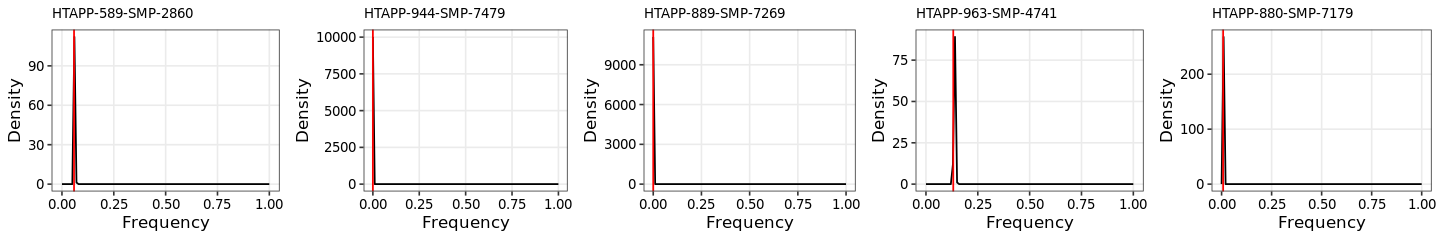

In [50]:
# plot target cell type frequency distribution for each sample.
#Indicated in red is the frequency at which the probability of observing a higher frequency is the confidence level (conf).
options(repr.plot.width = 12, repr.plot.height =2)
pl=plot_density(train_c)
cowplot::plot_grid(plotlist = pl,ncol=5)

In [53]:
# calculate deiscrete and continuous number of samples with (positive) and without (negative) enough cells of the target cell type 
train_s=train_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
train_s[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc)] # discrete fraction of positive samples
train_s[,ftc_cont:=qbeta(p=c(1-conf),shape1=1+ftc_c,shape2=1+ftc_nc)] #continuous fraction of discrete samples
#Rough estimates for the number of smaples needed
train_s[,Nc:=minS/ftc,] #discrete estimate
train_s[,Nc_cont:=minS/ftc_cont,] #continuous estimate
train_s[,Nc_low:=minS/qbeta(p=c(1-conf),shape1=1+Ntc+1,shape2=1+Nntc-1),] #discrete estimate if one more sample was positive
train_s[,Nc_high:=minS/qbeta(p=c(1-conf),shape1=1+Ntc-1,shape2=1+Nntc+1),] #discrete estimate if one more sample was positive

# Adjust the continuous estimate such that averaged across 1000 sampling experiments the desired probability of success (conf) is reached. 
#--> Nc_ref is the recommended number of samples.
train_s[,Nc_ref:=ceiling(Nc_cont),]
train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =1+ftc_c ,shape2 = 1+ftc_nc),lower.tail = FALSE))]
stopifnot(train_s$post_conf<conf)
while (train_s$post_conf<conf){
    train_s[,Nc_ref:=Nc_ref+1,]
    train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =1+ftc_c ,shape2 = 1+ftc_nc),lower.tail = FALSE))]
}

train_s

In [54]:
train_s

Ntc Nntc ftc_c   ftc_nc  ftc       ftc_cont  Nc       Nc_cont Nc_low 
1 3   2    2.98603 2.01397 0.2713384 0.2695011 18.42718 18.5528 11.9561
  Nc_high  Nc_ref post_conf
1 32.64536 21     0.9517001

In [55]:
#refine maxNc (number of cells profiled per sample) such that the minimum number of cells per sample can be recommended that retains the same result
Nc_pass=train_c$Nc[train_c$Nc<=maxNc]
if (length(Nc_pass)>0){
   maxNc_re=max(Nc_pass) 
}else{
    maxNc_re=maxNc
}
maxNc_re

[1] 6485

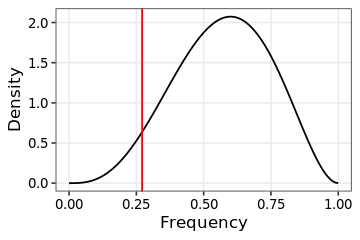

In [56]:
# plot the positive sample frequency distribution. 
#Indicated in red is the frequency at which the probability of observing a higher frequency is the confidence level (conf).
options(repr.plot.width = 3, repr.plot.height =2)
pl=plot_density(train_s)
cowplot::plot_grid(plotlist = pl,ncol=1)

In [57]:
#Calculate probability of success (p) (as defined in the setup) in dependence of the number of profiled samples/patients (size)
fs=data.table(f=seq(0,1,0.1))
fs[,d:=dbeta(x=f,shape1=1+train_s$ftc_c,shape2=1+train_s$ftc_nc)]

fs_screen=data.table()
for (size in c(1:100)){
    tmp=copy(fs)
    tmp[,p:=pbinom(q=minS-1,size = size,prob = f,lower.tail = FALSE),by=1:nrow(tmp)]
    tmp[,size:=size,]
    fs_screen=rbindlist(list(fs_screen,tmp))
}
ps=fs_screen[,.(p=sum(p*d)/sum(d)),by=size]

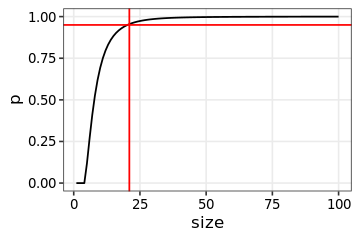

In [59]:
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(ps,aes(x=size,y=p))+geom_line()+geom_vline(xintercept = ceiling(train_s$Nc_ref),col="red")+geom_hline(yintercept = conf,col="red")

In [358]:
#Check the number of positive samples in the test set as "validation". In this case prediction holds true because all test samples happen to be positive. 
#Not really relevant, because the is no statistic. Proper validation needs sampling etc. and is included below.
test[cell_type==tc]

name               cell_type condition site_biopsy ER_biopsy PR_biopsy
1  HTAPP-231-SMP-6758 T         TST       Liver       Low       Negative 
2  HTAPP-889-SMP-7270 T         TST       Liver       Positive  Negative 
3  HTAPP-873-SMP-7119 T         TST       Liver       Negative  Negative 
4  HTAPP-895-SMP-7359 T         TST       Liver       Positive  Positive 
5  HTAPP-223-SMP-6755 T         TST       Liver       Negative  Negative 
6  HTAPP-223-SMP-7537 T         TST       Liver       Negative  Negative 
7  HTAPP-211-SMP-6751 T         TST       Liver       Negative  Negative 
8  HTAPP-947-SMP-7509 T         TST       Liver       Positive  Negative 
9  HTAPP-226-SMP-6757 T         TST       Liver       Negative  Negative 
10 HTAPP-997-SMP-7789 T         TST       Liver       Positive  Negative 
   HER2_biopsy N_cells
1  Negative    6407   
2  Negative     599   
3  Positive     223   
4  Negative     841   
5  Positive    2990   
6  Negative     458   
7  Negative    1685   
8  Negative     412   
9  Negative    1431   
10 Negative     181

### 2 Comprehensive assessment and validation with different settings and parameters

#### 2.1 A function to predict and validate the number of samples that need to be profiled in order to fulfil the specified requirements (used in all subsequent steps)

In [6]:
# This function is used as the core of all subsequent analysis and streamlines the step-wise process from section 1. 
#Additionnally it provides the possibility for within and cross-sample validation.
#Parameters:
#sub - Subset of the data to use for the analysis. (dataTable where each row denotes the number of cells of a given cell type in a given sample: name|cell_type|N_cells)
#tc - Target cell type (cell type of which a certain number of cells (minC) needs to be detected in a certain number of samples (minS))
#prior_sf - Prior expectation of the fraction of positive samples (range: 0-1)
#weight - The (hypothetical) number of samples the prior_sf estimate is based on (How sure are you your prior is correct?). The higher, the more influence prior_sf gets compared to what is seen in the data. Set to 0 to not use a prior.
#sample - number of samples used to for training/predicting. Must be smaller than the total number of samples available in the dataset.
#sample_same - If TRUE, use the same number of samples in the test set as are in the training set (sample). If FALSE, use all samples that are not in the training set.
#seed - Random seed for sample selecetion.

#----------Specify requirements here-------------------------------------------------------
#minC - Minimum number of cells from cell type of interest required
#minS - Minimum number of samples with minC cells (referred to as "positive samples")
#conf - Required confidence level of prediction
#maxNc - Maximum number of cells that can be sampled per sample
#------------------------------------------------------------------------------------------
#maxS - Maximum number of samples to be considered for the success-probability plot.
#max_cross - Number of random sample samplings ("cross-validation" loops)
#same - If TRUE, do validation using samplings from the traing-set distribution. If FALSE, do validation using samplings from the test-set (unseen samples) distribution.
#do.test - If TRUE, perfom validation. If FALSE, no validation is run (saves time).
#progress - If TRUE, show progress.


get_sampleN=function(sub,tc,prior_sf=0.5,weight=0,sample=5,sample_same=FALSE,seed=42,minC=50,minS=5,conf=0.95,maxNc=8000,maxS=100,max_cross=100,same=FALSE,do.test=FALSE,progress=TRUE){
    
    #Set up beta distribution parameters
    sa=1+prior_sf*weight
    sb=1+(1-prior_sf)*weight
    
    
    #set up train and test sample groupings
    all_samples=unique(sub$name)
    set.seed(seed)

    if (choose(k = sample,n=length(all_samples))>200000){
        split=list()
        for (i in c(1:max_cross)){
            split[[i]]=sample(all_samples,sample,replace = FALSE)}  
    }else{
        comb_mat=combn(all_samples,sample)
        split=as.list(as.data.frame(comb_mat[,sample(ncol(comb_mat),min(c(ncol(comb_mat),max_cross)),replace = FALSE),drop=FALSE],stringsAsFactors = FALSE))}

    #loop through the sample groupings
    res=data.table()
    ps=data.table()
    test_res=data.table()
    
    for (i in 1:length(split)){
        train_samples=split[[i]]    
        train=sub[name%in%train_samples]
        if (same==FALSE){
            if (sample_same==FALSE){
                test=sub[!name%in%train_samples]
            }else{
                test=sub[name%in%sample(unique(name)[!unique(name)%in%train_samples],sample)]}
        }else{
            test=train
        }
        
        #train calculations    
        train_c=train[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
        train_c[is.na(train_c)]=0
        train_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
        train_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
        train_c[,Nc:=minC/ftc,]
        
        train_s=train_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
        train_s[,ftc:=qbeta(p=c(1-conf),shape1=sa+Ntc,shape2=sb+Nntc)]
        train_s[,ftc_cont:=qbeta(p=c(1-conf),shape1=sa+ftc_c,shape2=sb+ftc_nc)]
        train_s[,Nc:=minS/ftc,]
        train_s[,Nc_cont:=minS/ftc_cont,]
        
        #refine number of recommended samples to achieve the decired confidence level
        train_s[,Nc_ref:=ceiling(Nc_cont),]
        train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
        if (progress==TRUE){
            message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
        }
        if(train_s$post_conf<conf){
            cond="(train_s$post_conf<conf)"
            add=1
        }else if (train_s$post_conf>conf){
            cond="(train_s$post_conf>conf)"
            add=-1
        }else{cond=FALSE}
        while (eval(parse(text=cond))){
            train_s[,Nc_ref:=Nc_ref+add,]
            train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
            if (progress==TRUE){
                message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
            }
        }   
        while (train_s$post_conf<conf){
            train_s[,Nc_ref:=Nc_ref+1,]
            train_s[,post_conf:=mean(pbinom(minS-1,Nc_ref,prob = rbeta(1000,shape1 =sa+ftc_c ,shape2 = sb+ftc_nc),lower.tail = FALSE))]
            if (progress==TRUE){
                message('\r',paste0(sample,"/",train_s$Nc_ref,"/",train_s$post_conf,"/",sa,"/",sb),appendLF = FALSE)
            }
        }
      
        #refine maxNc such that the minimum number of cells per sample can be recommended that retains the same result
        Nc_pass=train_c$Nc[train_c$Nc<=maxNc]
        if (length(Nc_pass)>0){
           maxNc_re=max(Nc_pass) 
        }else{
            maxNc_re=maxNc
        }
    
        #test calculations    
        if (do.test==TRUE){
            test_c=test[,.(Ntc=N_cells[cell_type==tc],Nntc=sum(N_cells[cell_type!=tc])),by="name"]
            test_c[is.na(test_c)]=0
            test_c[,ftc:=qbeta(p=c(1-conf),shape1=1+Ntc,shape2=1+Nntc),by=name]
            test_c[,ptc:=mean(pbinom(minC-1,maxNc,prob = rbeta(1000,shape1 =1+Ntc ,shape2 = 1+Nntc),lower.tail = FALSE)),by=name]
            test_c[,Nc:=minC/ftc,]
            test_s=test_c[,.(Ntc=sum(Nc<=maxNc),Nntc=sum(Nc>maxNc),ftc_c=sum(ptc),ftc_nc=sum(1-ptc))]
            freqs=rbeta(n=1000, shape1=sa+test_s$ftc_c,shape2=sb+test_s$ftc_nc) # sample "success" frequencies from beta distribution
            hit_rate=pbinom(minS-1,train_s$Nc_ref,prob = freqs,lower.tail = FALSE)
            test_res=rbindlist(list(test_res,data.table(Nsample=sample,i=i,train_samples=paste0(train_samples,collapse = "|"),test_samples=paste0(unique(test$name),collapse = "|"),freq=freqs, hit_rate=hit_rate,
                                                        Nc_h=minS/freqs,Nc_ref=train_s$Nc_ref,post_conf=train_s$post_conf,a_test=test_s$ftc_c,b_test=test_s$ftc_nc,a_train=train_s$ftc_c,b_train=train_s$ftc_nc)))    
        }
    # calculate success probability in dependence of number of assessed samples
        fs=data.table(f=seq(0,1,0.1))
        fs[,d:=dbeta(x=f,shape1=sa+train_s$ftc_c,shape2=sb+train_s$ftc_nc)]
        fs_screen=data.table()
        for (size in c(1:maxS)){
            tmp=copy(fs)
            tmp[,p:=pbinom(q=minS-1,size = size,prob = f,lower.tail = FALSE),by=1:nrow(tmp)]
            tmp[,size:=size,]
            fs_screen=rbindlist(list(fs_screen,tmp))
        }
        ps_tmp=fs_screen[,.(p=sum(p*d)/sum(d)),by=size]
        ps=rbindlist(list(ps,ps_tmp[,c("i","sample","samples"):=list(i,sample,paste0(train_samples,collapse = "|")),]))
            
        res_tmp=data.table(i=i,sample=sample,samples=paste0(train_samples,collapse = "|"),Nsamples=train_s$Nc,Nsamples_cont=train_s$Nc_cont,Nsamples_ref=train_s$Nc_ref,post_conf=train_s$post_conf,maxNc_re=maxNc_re)
        res=rbindlist(list(res,res_tmp))
    }
    return(list(res,ps,test_res)) 
}

#### 2.2 Sweep number of samples used to train

In [15]:
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]

In [9]:
res=data.table()
ps=data.table()
totN=length(unique(sub$name))
for (n in 1:totN){
    message('\r',paste0(n,"/",totN),appendLF = FALSE)
    ret=get_sampleN(sub,tc='T',sample=n)
    res=rbindlist(list(res,ret[[1]]))
    ps=rbindlist(list(ps,ret[[2]]))
}

21/14/0.956947475370735

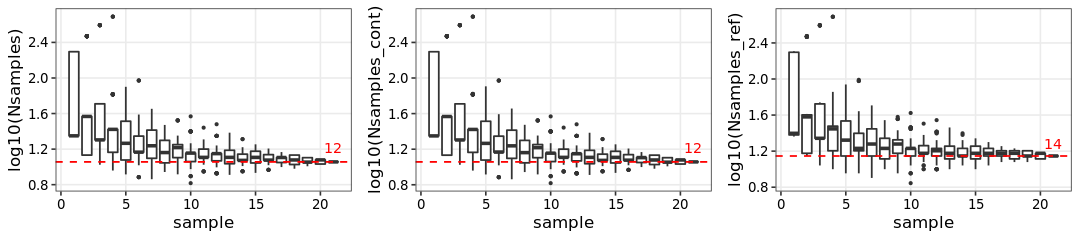

In [10]:
#Plot recommended number of samples in dependence of the number of samples used to make the prediction/recommendattion. 
#The 3 slightly different ways of calculating the recommended number of samples. Nsamples_ref is considered the most accurate one and is (internally) used in further analysis.
options(repr.plot.width = 9, repr.plot.height =2)
lim=res[sample==max(sample)]$Nsamples
lim_cont=res[sample==max(sample)]$Nsamples_cont
lim_ref=res[sample==max(sample)]$Nsamples_ref
p1=ggplot(res,aes(x=sample,y=log10(Nsamples),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim),col="red",lty=20)+annotate(geom="text",label=ceiling(lim),y=log10(lim+5),x=res[sample==max(sample)]$sample,col="red",size=3)
p2=ggplot(res,aes(x=sample,y=log10(Nsamples_cont),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim_cont),col="red",lty=20)+annotate(geom="text",label=ceiling(lim_cont),y=log10(lim_cont+5),x=res[sample==max(sample)]$sample,col="red",size=3)
p3=ggplot(res,aes(x=sample,y=log10(Nsamples_ref),group=sample))+geom_boxplot(outlier.size = 0.5)+geom_hline(yintercept = log10(lim_ref),col="red",lty=20)+annotate(geom="text",label=ceiling(lim_ref),y=log10(lim_ref+5),x=res[sample==max(sample)]$sample,col="red",size=3)
cowplot::plot_grid(p1,p2,p3,ncol = 3)

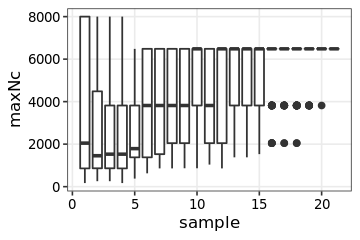

In [11]:
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(res,aes(x=sample,y=maxNc_ref,group=sample))+geom_boxplot()

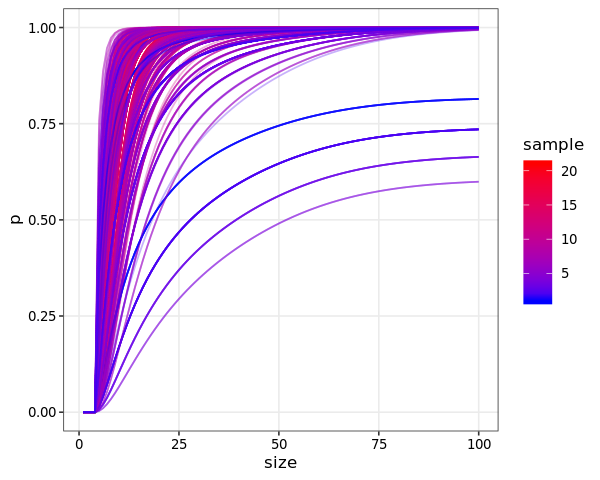

In [12]:
#Success probablility in dependence of the number of profiled samples (size), shown separately for each of the 100 rendom samplings.
options(repr.plot.width = 5, repr.plot.height =4)
ggplot(ps,aes(x=size,y=p,group=samples,col=sample))+geom_line(alpha=0.3)+scale_color_gradient(high="red",low="blue") #+facet_wrap(~sample,ncol=3)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 383 rows containing missing values (geom_smooth)."

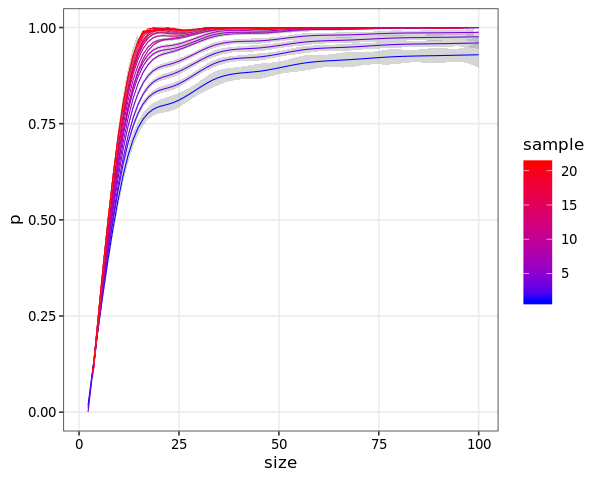

In [13]:
#Same as above but combined per number of train samples (sample)
options(repr.plot.width = 5, repr.plot.height =4)
ggplot(ps,aes(x=size,y=p,group=sample,col=sample))+geom_smooth(size=0.3)+scale_color_gradient(high="red",low="blue")+ylim(c(0,1)) #+facet_wrap(~sample,ncol=3)

#### 2.3 Validation analysis using all non-train samples as test samples (assessed across different numbers of training samples)

In [9]:
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]

In [16]:
sub_t=sub[,.(Ntc=N_cells[cell_type=="T"],Nntc=sum(N_cells[cell_type!="T"])),by="name"]
sub_t[is.na(sub_t)]=0
sub_t[,f:=Ntc/Nntc,]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


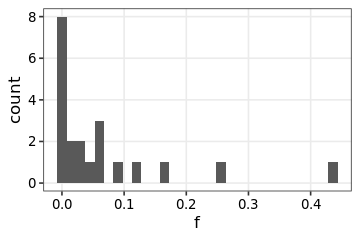

In [9]:
#Histogram of target cell frequencies
options(repr.plot.width = 3, repr.plot.height =2)
ggplot(sub_t, aes(x=f))+geom_histogram()

In [10]:
val=data.table()
val_cross=data.table()
totN=length(unique(sub$name))
for (n in 1:totN){
    ret=get_sampleN(sub,tc='T',sample=n,max_cross = 1000,conf = 0.95,do.test = TRUE,same = TRUE)
    ret_cross=get_sampleN(sub,tc='T',sample=n,max_cross = 1000,conf = 0.95,do.test = TRUE,same = FALSE)
    val=rbindlist(list(val,ret[[3]]))
    val_cross=rbindlist(list(val_cross,ret_cross[[3]]))
}

21/14/0.956947475370735Warning message in rbeta(1000, shape1 = 1 + Ntc, shape2 = 1 + Nntc):
"NAs produced"

In [107]:
save(val,file = paste0(out,"/validation.RData"))
save(val_cross,file = paste0(out,"/validation_cross.RData"))

In [11]:
val[,mode:="same",]
val_cross[,mode:="cross",]
val_all=rbindlist(list(val,val_cross))

In [12]:
head(val_all)

Nsample i train_samples      test_samples       freq      hit_rate  Nc_ref
1 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.5784313 0.9999569 24    
2 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.9257602 1.0000000 24    
3 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.8767168 1.0000000 24    
4 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.3585294 0.9648670 24    
5 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.8173718 1.0000000 24    
6 1       1 HTAPP-880-SMP-7179 HTAPP-880-SMP-7179 0.5459776 0.9998460 24    
  post_conf a_test    b_test     a_train   b_train   mode
1 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same
2 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same
3 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same
4 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same
5 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same
6 0.9592153 0.9885973 0.01140269 0.9892022 0.0107978 same

In [13]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate)),by=c("i","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode")]

In [26]:
head(val_comb)

i Nsample train_samples      test_samples       Nc_ref post_conf a_test      
1 1 1       HTAPP-880-SMP-7179 HTAPP-880-SMP-7179  24    0.9592153 9.885973e-01
2 2 1       HTAPP-889-SMP-7269 HTAPP-889-SMP-7269 199    0.9508142 8.295700e-33
3 3 1       HTAPP-589-SMP-2860 HTAPP-589-SMP-2860  25    0.9602832 1.000000e+00
4 4 1       HTAPP-963-SMP-4741 HTAPP-963-SMP-4741  25    0.9532986 1.000000e+00
5 5 1       HTAPP-944-SMP-7479 HTAPP-944-SMP-7479 199    0.9571376 1.433361e-35
6 6 1       HTAPP-231-SMP-6758 HTAPP-231-SMP-6758  24    0.9549086 1.000000e+00
  b_test     a_train      b_train   mode mean_hit_rate tc_f_train tc_z_train
1 0.01140269 9.892022e-01 0.0107978 same 0.9389022     0.06523252 8         
2 1.00000000 2.850959e-36 1.0000000 same 0.9559401     0.06523252 8         
3 0.00000000 1.000000e+00 0.0000000 same 0.9562189     0.06523252 8         
4 0.00000000 1.000000e+00 0.0000000 same 0.9554624     0.06523252 8         
5 1.00000000 1.953463e-32 1.0000000 same 0.9537967     0.06523252 8         
6 0.00000000 1.000000e+00 0.0000000 same 0.9540618     0.06523252 8         
  tc_f_test  tc_z_test d_tc_f d_tc_z
1 0.06523252 8         0      0     
2 0.06523252 8         0      0     
3 0.06523252 8         0      0     
4 0.06523252 8         0      0     
5 0.06523252 8         0      0     
6 0.06523252 8         0      0

In [34]:
get_ct_freq=function(dat,sample_str){
    samples=unlist(strsplit(sample_str,"\\|"))
    freq=mean(dat[name%in%samples,]$f)
    zeros=sum(dat[name%in%samples,]$f==0)
    list(freq,zeros)
}

val_comb[,c("tc_f_train","tc_z_train"):=get_ct_freq(sub_t,train_samples),by=c("i","Nsample","mode")]
val_comb[,c("tc_f_test","tc_z_test"):=get_ct_freq(sub_t,test_samples),by=c("i","Nsample","mode")]
val_comb[,d_tc_f:=tc_f_train-tc_f_test,by=c("i","Nsample","mode")]
val_comb[,d_tc_z:=tc_z_train-tc_z_test,by=c("i","Nsample","mode")]

Warning message:
"Removed 2 rows containing missing values (geom_errorbar)."

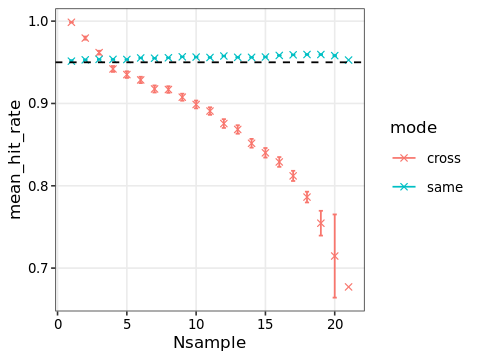

In [65]:
options(repr.plot.width = 4, repr.plot.height =3)
ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")

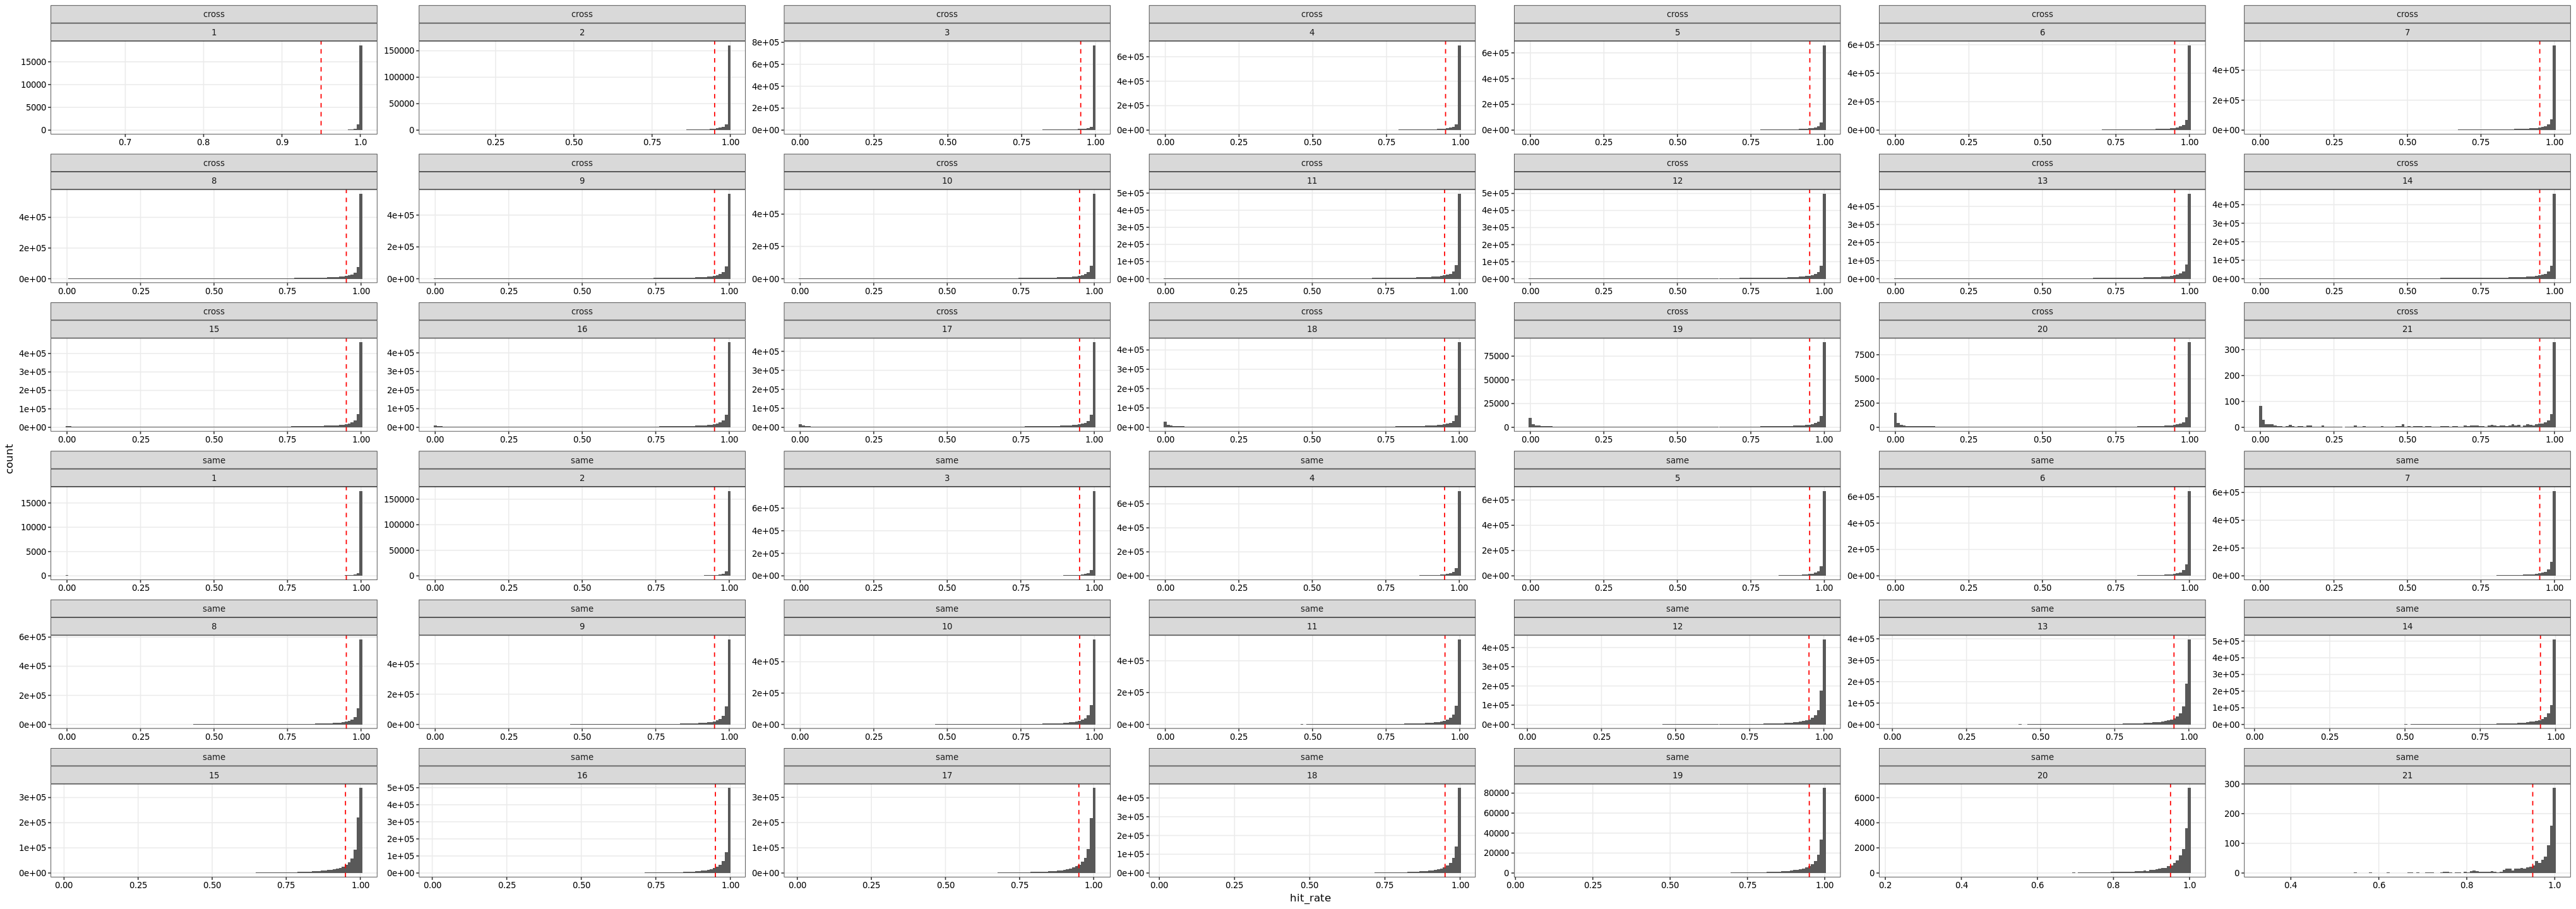

In [73]:
options(repr.plot.width = 34, repr.plot.height =12)
ggplot(val_all, aes(x=hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample, scale="free")

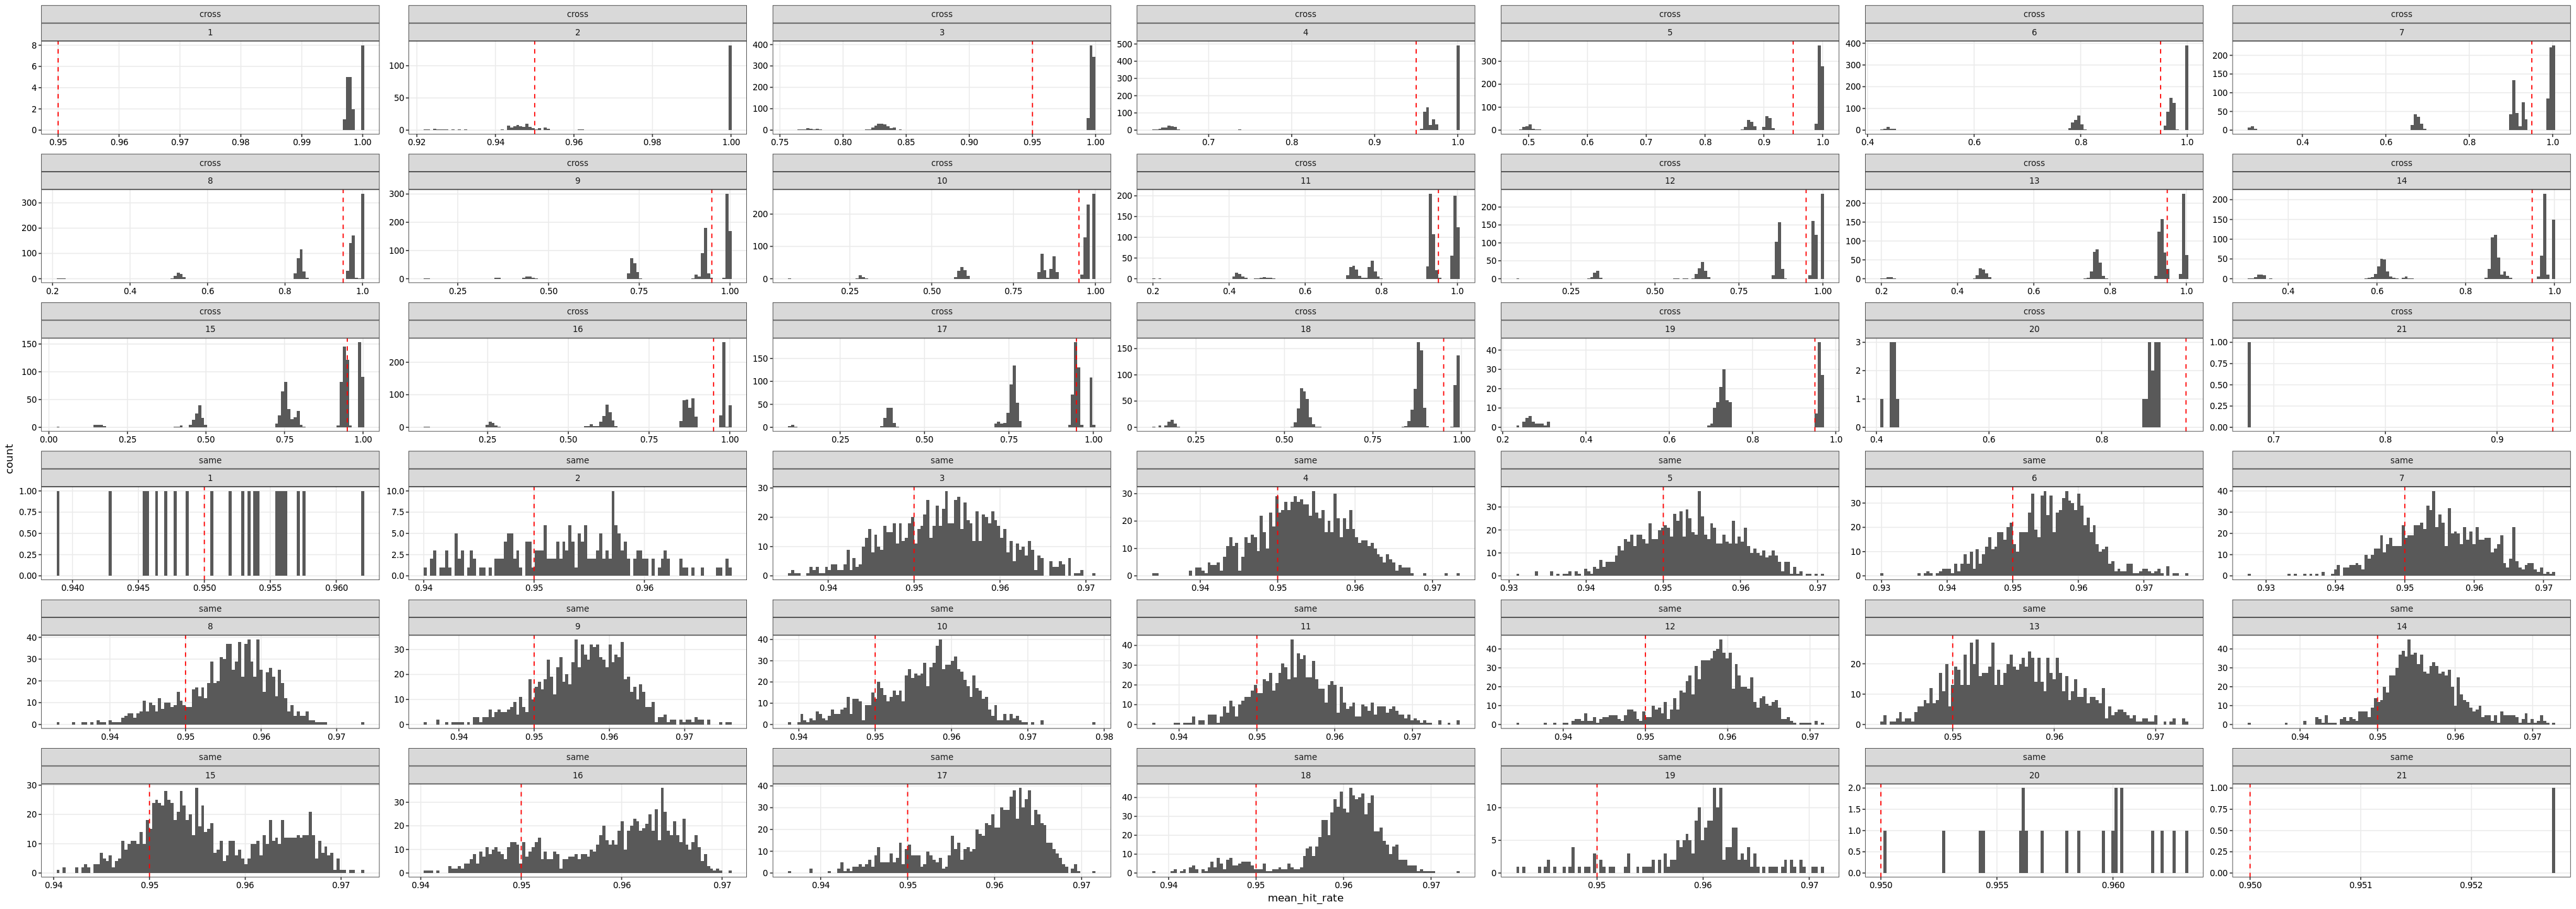

In [14]:
options(repr.plot.width = 34, repr.plot.height =12)
ggplot(val_comb, aes(x=mean_hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample, scale="free")

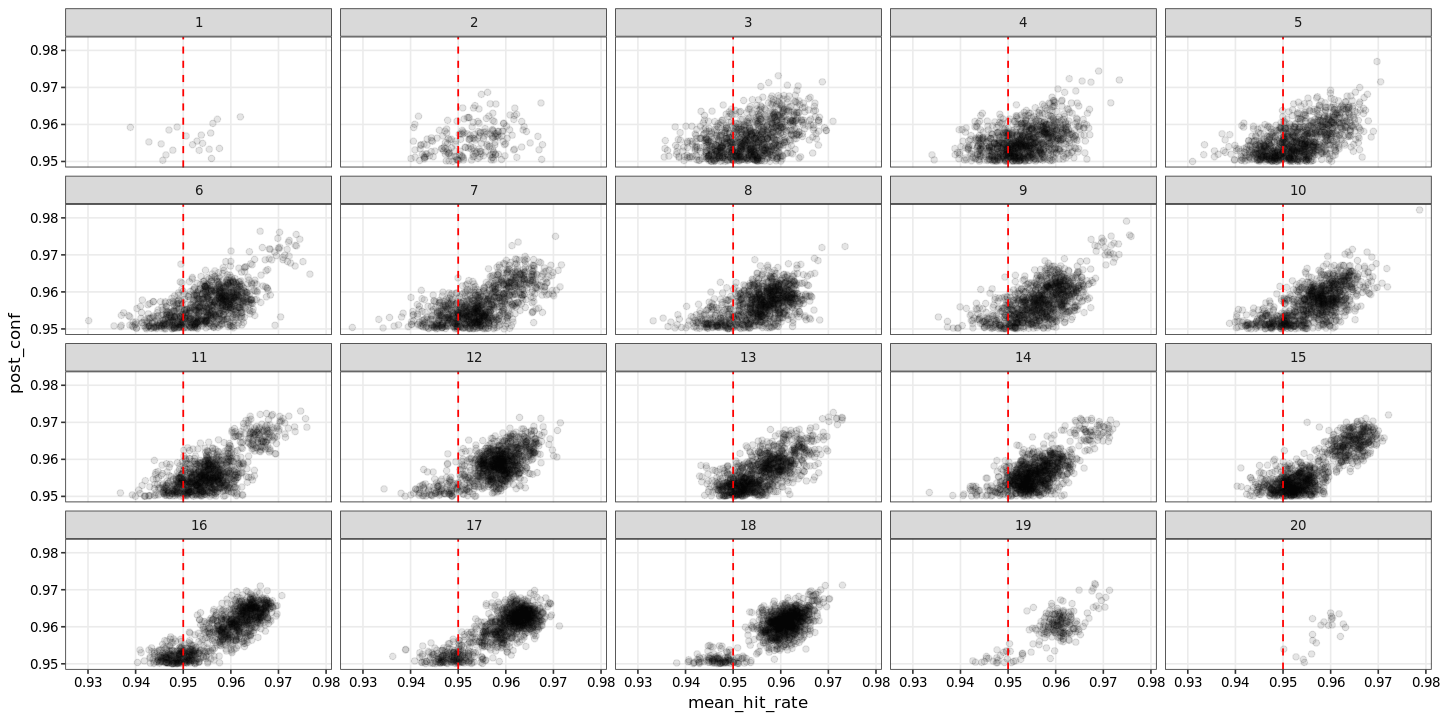

In [30]:
options(repr.plot.width = 12, repr.plot.height =6)
ggplot(val_comb[Nsample<21&mode=="same"], aes(x=mean_hit_rate,y=post_conf))+geom_point(alpha=0.1)+facet_wrap(~Nsample)+geom_vline(xintercept = 0.95,lty=20,col="red")

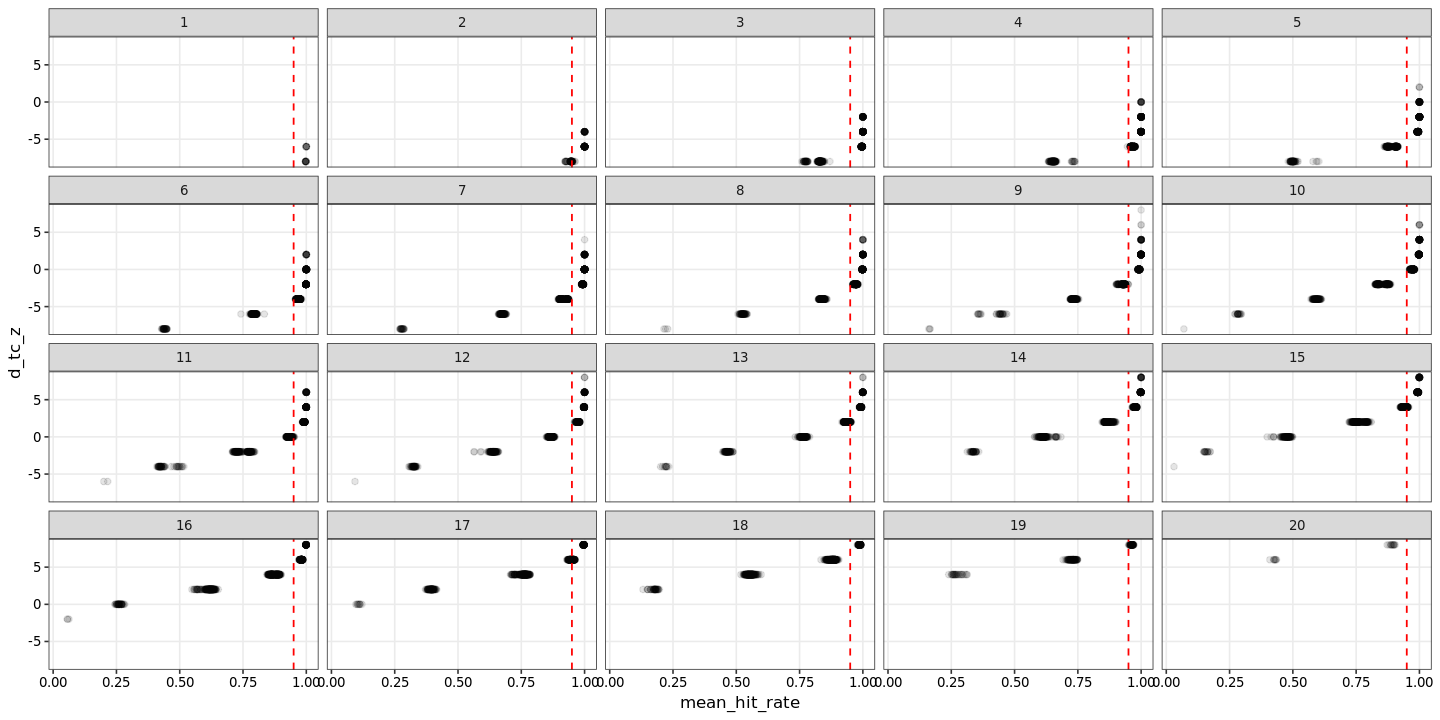

In [38]:
options(repr.plot.width = 12, repr.plot.height =6) 
ggplot(val_comb[Nsample<21&mode=="cross"], aes(x=mean_hit_rate,y=d_tc_z))+geom_point(alpha=0.1)+facet_wrap(~Nsample)+geom_vline(xintercept = 0.95,lty=20,col="red")

#### 2.4 Cross-validation is only sensible with the same number of test an training samples (--> same as 2.3 but using same number of train and test samples)

In [9]:
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]

In [20]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN=floor(totN/2)
totN

[1] 10

In [21]:
val=data.table()
val_cross=data.table()
for (n in 1:totN){
    ret_def<-get_sampleN(sub,tc='T',sample=n,sample_same = TRUE,max_cross = 1000,conf = 0.95,do.test = TRUE)
    ret_def_same<-get_sampleN(sub,tc='T',sample=n,max_cross = 1000,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]]))
    val_cross=rbindlist(list(val_cross,ret_def[[3]]))
}

10/17/0.960855301000092

In [22]:
save(val,file = paste0(out,"/validation_10.RData"))
save(val_cross,file = paste0(out,"/validation_cross_10.RData"))

In [23]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val=rbindlist(list(val_cross,val))

In [24]:
val_comb=val[,.(mean_hit_rate=mean(hit_rate)),by=c("i","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode")]

In [25]:
get_ct_freq=function(dat,sample_str){
    samples=unlist(strsplit(sample_str,"\\|"))
    freq=mean(dat[name%in%samples,]$f)
    zeros=sum(dat[name%in%samples,]$f==0)
    list(freq,zeros)
}

val_comb[,c("tc_f_train","tc_z_train"):=get_ct_freq(sub_t,train_samples),by=c("i","Nsample","mode")]
val_comb[,c("tc_f_test","tc_z_test"):=get_ct_freq(sub_t,test_samples),by=c("i","Nsample","mode")]
val_comb[,d_tc_f:=tc_f_train-tc_f_test,by=c("i","Nsample","mode")]
val_comb[,d_tc_z:=tc_z_train-tc_z_test,by=c("i","Nsample","mode")]

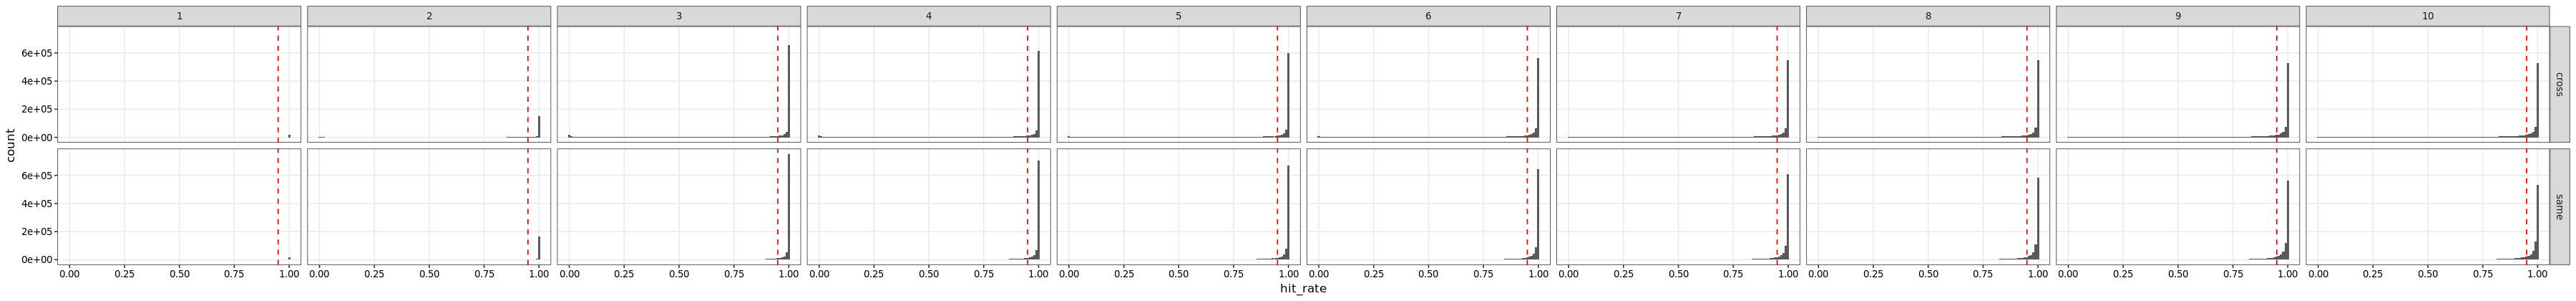

In [30]:
options(repr.plot.width = 30, repr.plot.height =3.5)
ggplot(val, aes(x=hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_grid(mode~Nsample)

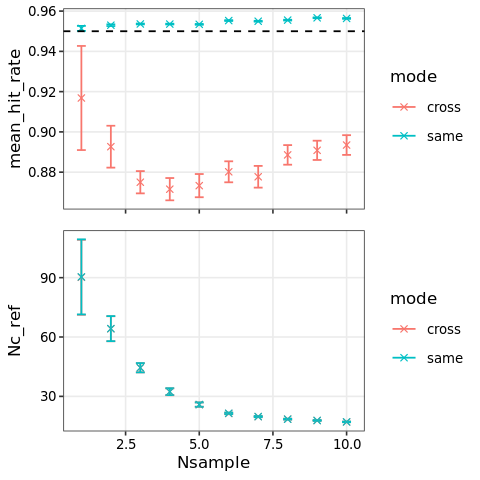

In [61]:
options(repr.plot.width = 4, repr.plot.height =4)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())

p2=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)
grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2), size = "first"))
#grid.arrange(p1, p2, nrow=2)

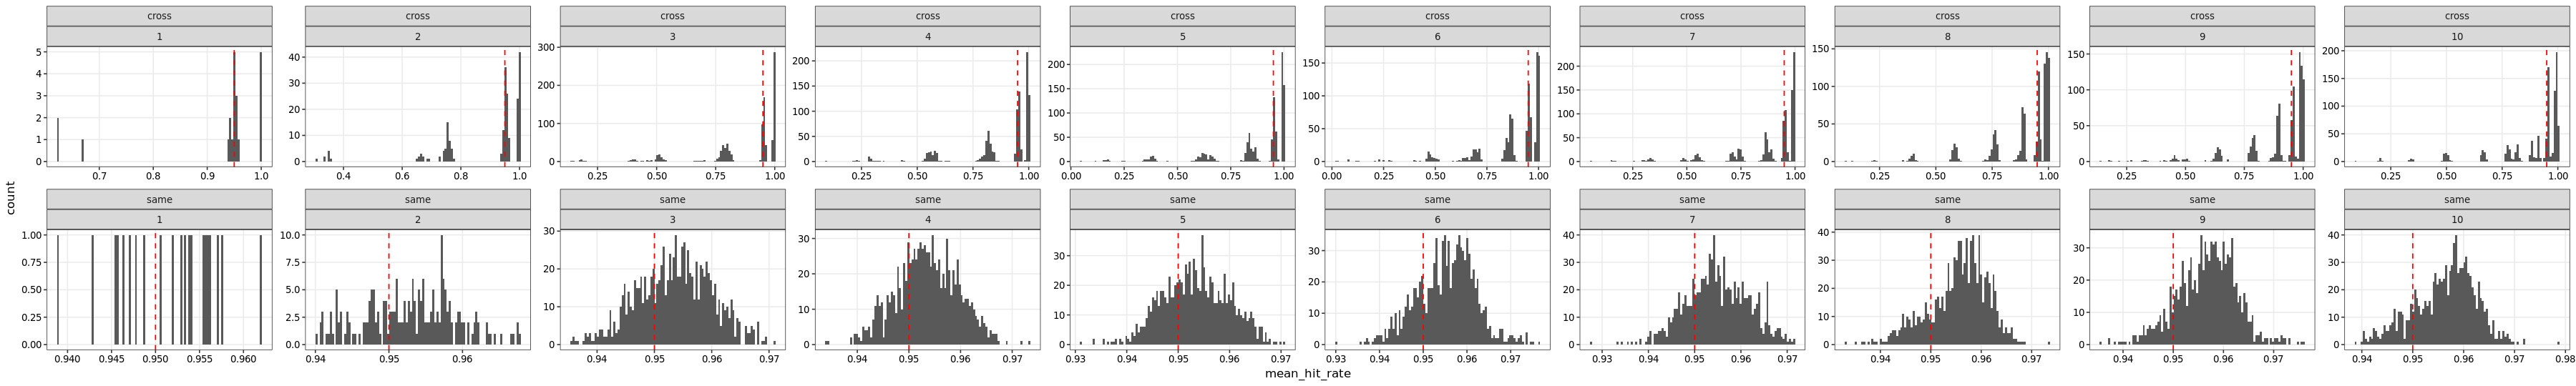

In [38]:
options(repr.plot.width = 30, repr.plot.height =4.5)
ggplot(val_comb, aes(x=mean_hit_rate))+geom_histogram(bins = 100)+geom_vline(xintercept = 0.95,lty=20,col="red")+facet_wrap(mode~Nsample,scale="free",nrow=2)

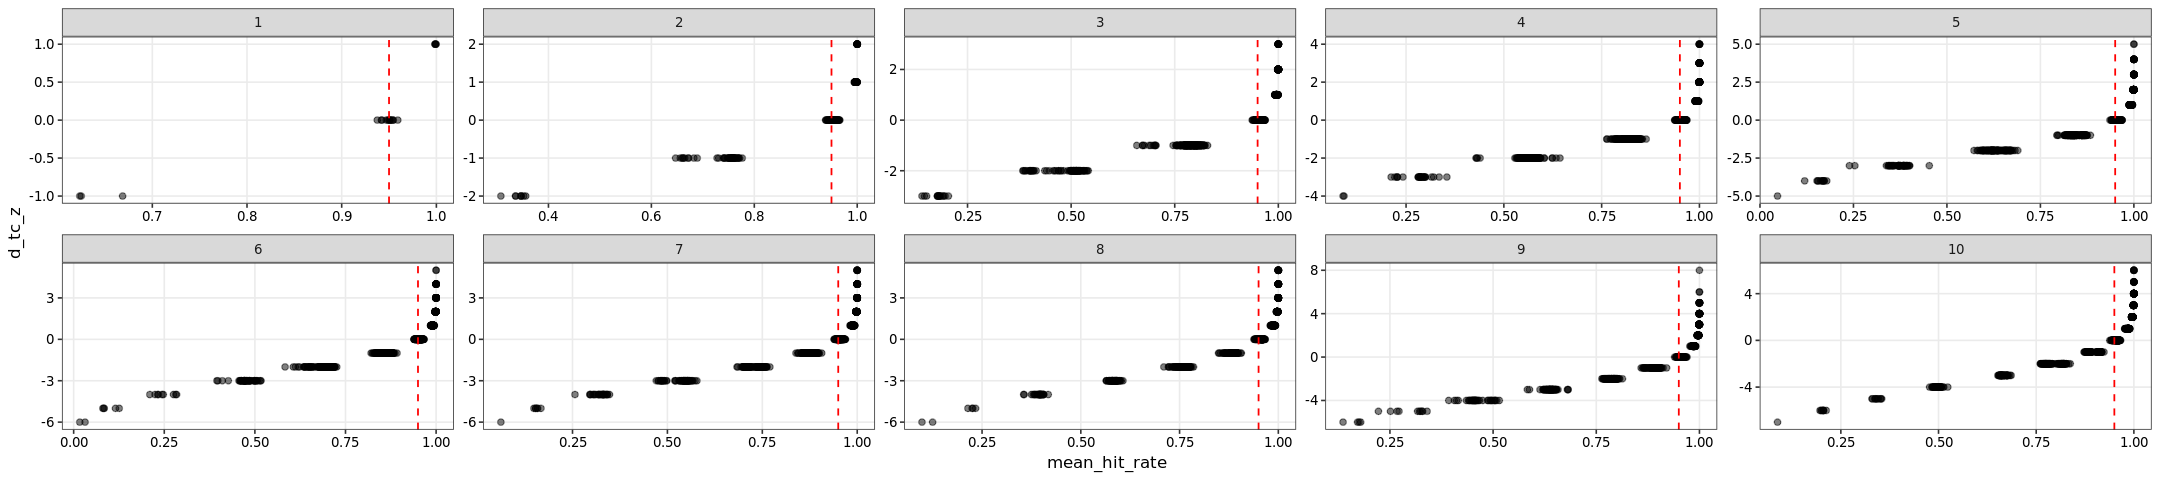

In [42]:
options(repr.plot.width = 18, repr.plot.height =4)
ggplot(val_comb[mode=="cross"],aes(y=d_tc_z,x=mean_hit_rate))+geom_point(alpha=0.5)+geom_vline(xintercept = 0.95,col="red",lty=20)+facet_wrap(~Nsample,scale="free",nrow=2)

#### 2.5 Compare different cell types

In [8]:
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]

In [9]:
sub_ct=melt(sub[,.(cts=.N,T=N_cells[cell_type=="T"]/sum(N_cells),B=N_cells[cell_type=="B"]/sum(N_cells),MBC=N_cells[cell_type=="MBC"]/sum(N_cells)),by="name"],id.vars = "name",na.rm = FALSE)
sub_ct[is.na(sub_ct)]=0

Warning message in melt.data.table(sub[, .(cts = .N, T = N_cells[cell_type == "T"]/sum(N_cells), :
"'measure.vars' [cts, T, B, MBC] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


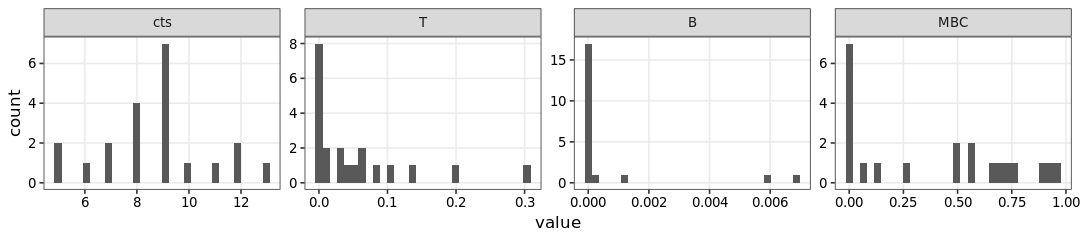

In [10]:
#Target cell type frequency distributions
options(repr.plot.width = 9, repr.plot.height =2)
ggplot(sub_ct, aes(x=value))+geom_histogram()+facet_wrap(~variable,nrow=1,scale="free")

In [11]:
# frequency of "positive samples" estimate
sub_ct[,sum(value>0.01)/.N,by="variable"]

variable V1       
1 cts      1.0000000
2 T        0.5714286
3 B        0.0000000
4 MBC      0.6666667

In [39]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN_half=floor(totN/2)
totN
totN_half

[1] 21

[1] 10

In [51]:
#Specify parameters for different cell types/runs. Here also using the positive sample frequency prior: (tc,prior_sf,weight) 
cts=list(c("T",0.5,5),c("B",0.0001,5),c("MBC",0.6,5),c("T",0,0),c("B",0,0),c("MBC",0,0))

In [52]:
val=data.table()
val_cross=data.table()
ps=data.table()
for (n in 1:totN){
    for (c in cts){
        ct=c[1]
        sf=as.numeric(c[2])
        w=as.numeric(c[3])
        if (n<=totN_half){
            ret_def<-get_sampleN(sub,tc = ct,prior_sf =sf ,weight = w,sample=n,sample_same = TRUE,max_cross = 100,conf = 0.95,do.test = TRUE)
            val_cross=rbindlist(list(val_cross,ret_def[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
        }
    ret_def_same<-get_sampleN(sub,tc = ct,prior_sf =sf,weight = w,sample=n,max_cross = 100,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
    ps=rbindlist(list(ps,ret_def_same[[2]][,c("ct","sf","w"):=list(ct,sf,w),]))    
        }
}

21/13/0.966680816959601/1/1

In [53]:
save(val,file = paste0(out,"/validation_ct.RData"))
save(val_cross,file = paste0(out,"/validation_cross_ct.RData"))
save(ps,file = paste0(out,"/success_prob_ct.RData"))

In [6]:
load(paste0(out,"/validation_ct.RData"))
load(paste0(out,"/validation_cross_ct.RData"))

In [7]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val_all=rbindlist(list(val_cross,val))

In [8]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate),sd_hit_rate=sd(hit_rate),mean_Nc_h=mean(Nc_h[Nc_h<quantile(Nc_h,0.9999)]),sd_Nc_h=sd(Nc_h[Nc_h<quantile(Nc_h,0.9999)])),by=c("i","ct","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode","sf","w")]

Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."

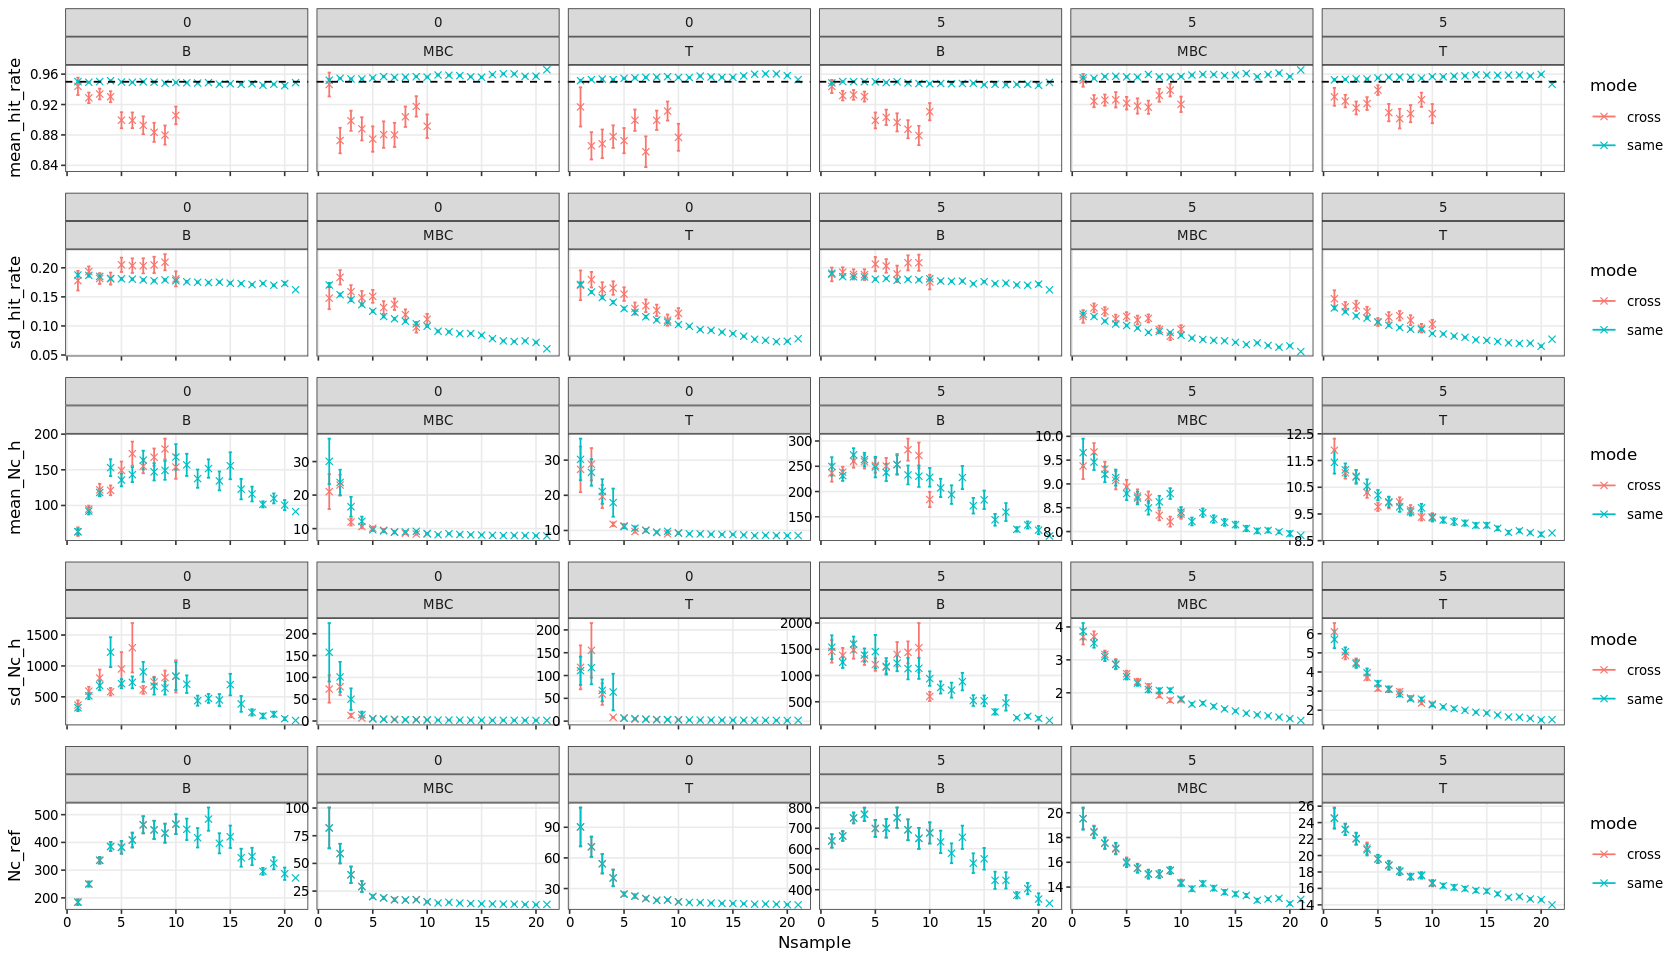

In [12]:
options(repr.plot.width = 14, repr.plot.height =8)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p2=ggplot(val_comb,aes(y=sd_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p3=ggplot(val_comb,aes(y=mean_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p4=ggplot(val_comb,aes(y=sd_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p5=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+facet_wrap(w~ct, nrow=1,scale="free_y")
grid::grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2),ggplotGrob(p3),ggplotGrob(p4),ggplotGrob(p5) ,size = "first"))
#grid.arrange(p1, p2, nrow=2)

In [16]:
val_comb[Nsample%in%c(10,19,21)&mode=="same",.(nCombis=.N,median_Nc_ref=median(Nc_ref),mean_Nc_ref=mean(Nc_ref),sd_Nc_ref=sd(Nc_ref)),by=c("ct","Nsample","w")]

ct  Nsample w nCombis median_Nc_ref mean_Nc_ref sd_Nc_ref  
1  T   10      5 100      17            16.67        3.5364052
2  B   10      5 100     542           676.72      515.6661687
3  MBC 10      5 100      14            14.31        2.4728628
4  T   10      0 100      17            17.06        5.4305905
5  B   10      0 100     375           465.87      355.3230613
6  MBC 10      0 100      14            15.25        4.2052757
7  T   19      5 100      14            14.72        1.0832051
8  B   19      5 100     308           405.75      273.2852277
9  MBC 19      5 100      13            13.09        0.8656754
10 T   19      0 100      14            14.58        1.1386684
11 B   19      0 100     246           324.95      220.7267782
12 MBC 19      0 100      13            12.88        1.0374795
13 T   21      5   1      14            14.00               NA
14 B   21      5   1     334           334.00               NA
15 MBC 21      5   1      13            13.00               NA
16 T   21      0   1      14            14.00               NA
17 B   21      0   1     272           272.00               NA
18 MBC 21      0   1      13            13.00               NA

#### 2.6 Same as above but in a larger, more heterogenious set (now all biopsy sites are included, not only liver)

In [9]:
sub=cell_counts[condition=="TST"]

In [10]:
sub_ct=melt(sub[,.(cts=.N,T=N_cells[cell_type=="T"]/sum(N_cells),B=N_cells[cell_type=="B"]/sum(N_cells),MBC=N_cells[cell_type=="MBC"]/sum(N_cells)),by="name"],id.vars = "name",na.rm = FALSE)
sub_ct[is.na(sub_ct)]=0

Warning message in melt.data.table(sub[, .(cts = .N, T = N_cells[cell_type == "T"]/sum(N_cells), :
"'measure.vars' [cts, T, B, MBC] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


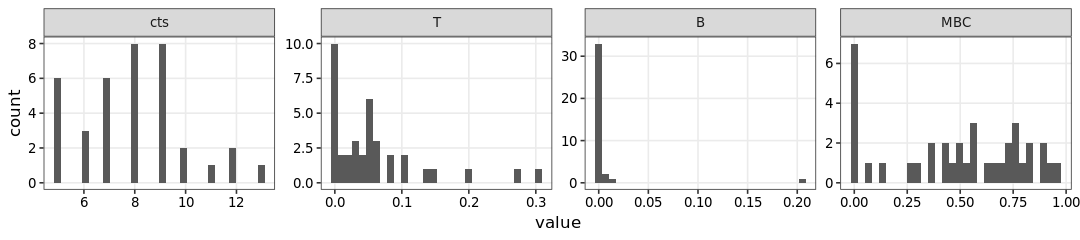

In [11]:
options(repr.plot.width = 9, repr.plot.height =2)
ggplot(sub_ct, aes(x=value))+geom_histogram()+facet_wrap(~variable,nrow=1,scale="free")

In [12]:
sub_ct[,sum(value>0.01)/.N,by="variable"]

variable V1        
1 cts      1.00000000
2 T        0.70270270
3 B        0.05405405
4 MBC      0.81081081

In [13]:
all_samples=unique(sub$name)
totN=length(unique(sub$name))
totN_half=floor(totN/2)
totN
totN_half

[1] 37

[1] 18

In [14]:
cts=list(c("T",0.7,5),c("B",0.05,5),c("MBC",0.8,5),c("T",0,0),c("B",0,0),c("MBC",0,0))

In [89]:
val=data.table()
val_cross=data.table()
ps=data.table()
for (c in cts){
    print(c[1])
    for (n in 1:totN){
        ct=c[1]
        sf=as.numeric(c[2])
        w=as.numeric(c[3])
        if (n<=totN_half){
            ret_def<-get_sampleN(sub,tc = ct,prior_sf =sf ,weight = w,sample=n,sample_same = TRUE,max_cross = 100,conf = 0.95,do.test = TRUE)
            val_cross=rbindlist(list(val_cross,ret_def[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
        }
    ret_def_same<-get_sampleN(sub,tc = ct,prior_sf =sf,weight = w,sample=n,max_cross = 100,conf = 0.95,same = TRUE,do.test = TRUE)
    val=rbindlist(list(val,ret_def_same[[3]][,c("ct","sf","w"):=list(ct,sf,w),]))
    ps=rbindlist(list(ps,ret_def_same[[2]][,c("ct","sf","w"):=list(ct,sf,w),]))    
        }
}

[1] "T"


37/11/0.971360817723098/4.5/2.5

[1] "B"


37/146/0.953327687380219/1.25/5.75

[1] "MBC"


37/9/0.966772921539835/5/2

[1] "T"


37/11/0.970618113146838/1/1

[1] "B"


37/143/0.953553305816054/1/1

[1] "MBC"


37/9/0.964678815144229/1/1

In [93]:
save(val,file = paste0(out,"/validation_ct_het.RData"))
save(val_cross,file = paste0(out,"/validation_cross_ct_het.RData"))
save(ps,file = paste0(out,"/success_prob_ct_het.RData"))

In [17]:
load(paste0(out,"/validation_ct_het.RData"))
load(paste0(out,"/validation_cross_ct_het.RData"))

In [18]:
val_cross[,mode:="cross",]
val[,mode:="same",]
val_all=rbindlist(list(val_cross,val))

In [19]:
val_comb=val_all[,.(mean_hit_rate=mean(hit_rate),sd_hit_rate=sd(hit_rate),mean_Nc_h=mean(Nc_h[Nc_h<quantile(Nc_h,0.9999)]),sd_Nc_h=sd(Nc_h[Nc_h<quantile(Nc_h,0.9999)])),by=c("i","ct","Nsample","train_samples","test_samples","Nc_ref","post_conf","a_test","b_test","a_train","b_train","mode","sf","w")]

Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."Warning message:
"Removed 6 rows containing missing values (geom_errorbar)."

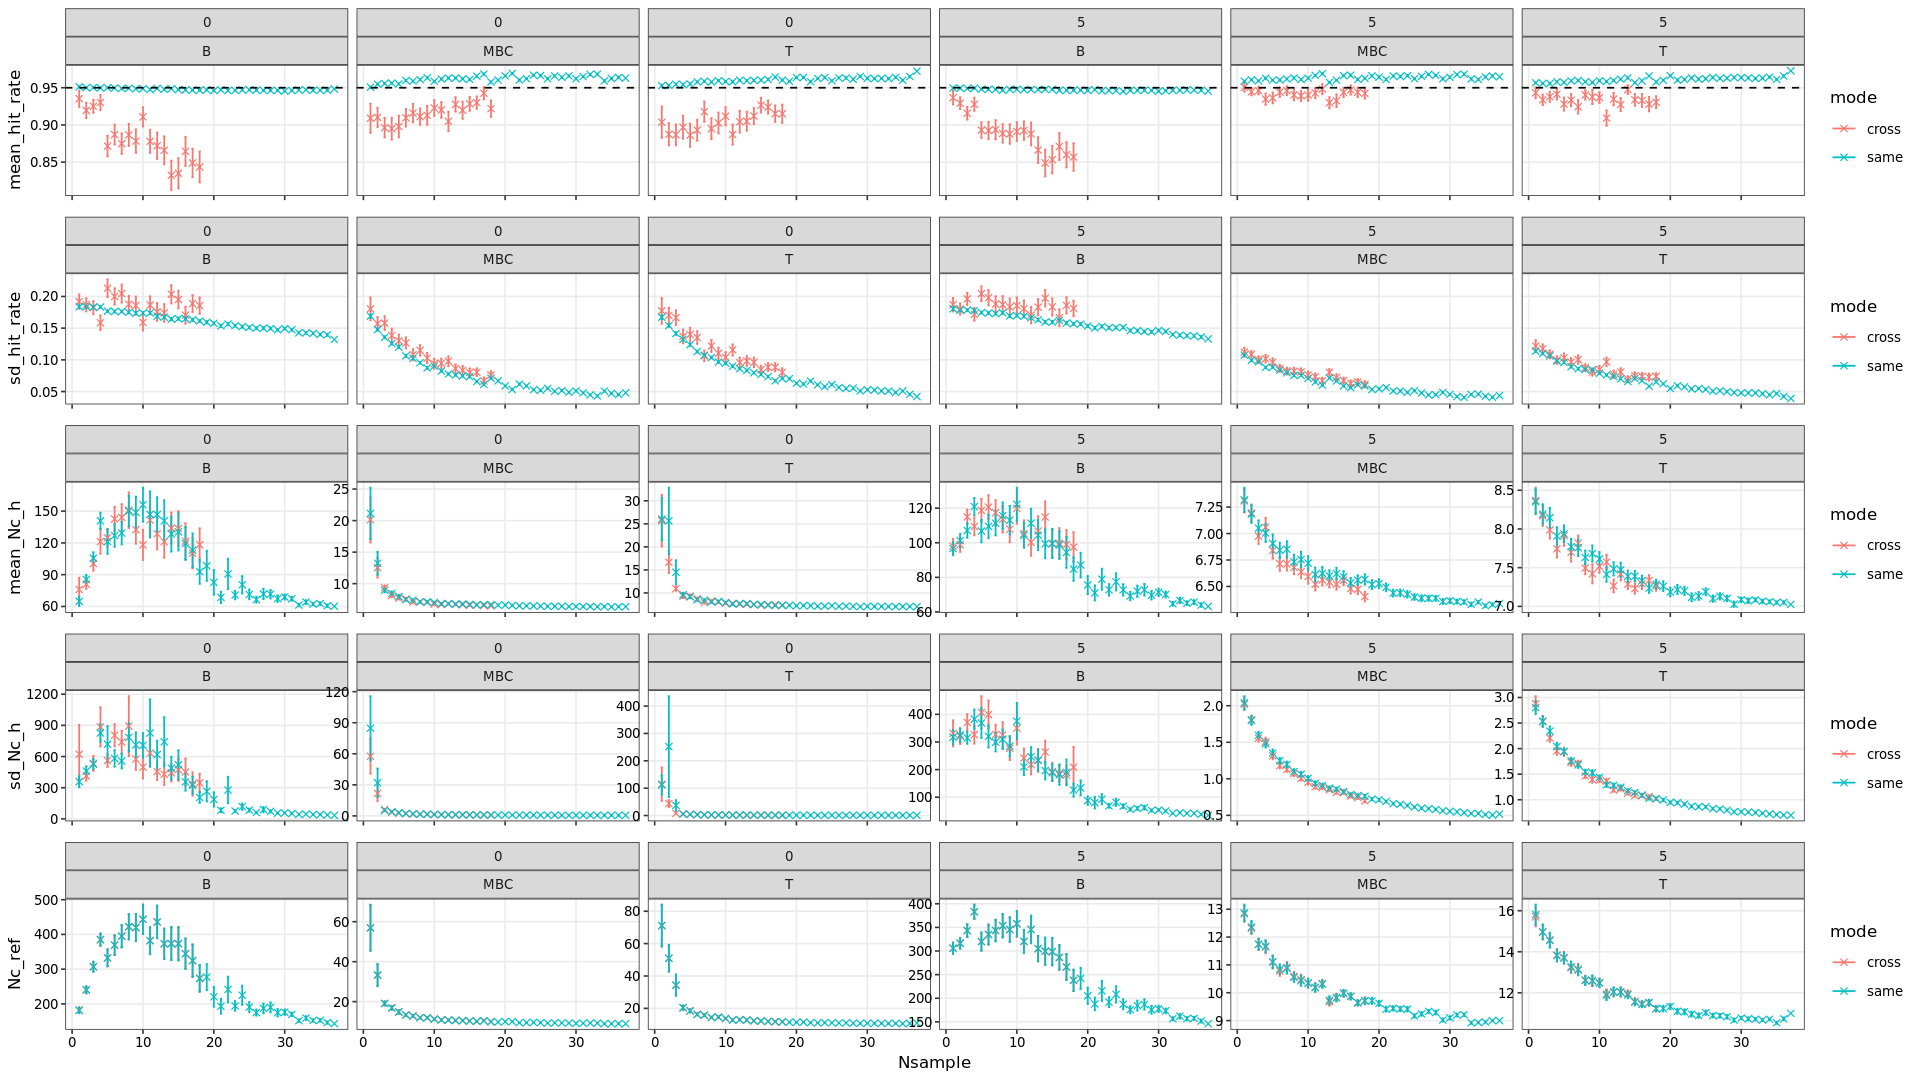

In [20]:
options(repr.plot.width = 16, repr.plot.height =9)
p1=ggplot(val_comb,aes(y=mean_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
geom_hline(yintercept=0.95,lty=20,color="black")+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p2=ggplot(val_comb,aes(y=sd_hit_rate,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1)

p3=ggplot(val_comb,aes(y=mean_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p4=ggplot(val_comb,aes(y=sd_Nc_h,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+
theme(axis.title.x = element_blank(), axis.text.x = element_blank())+facet_wrap(w~ct, nrow=1,scale="free_y")

p5=ggplot(val_comb,aes(y=Nc_ref,x=Nsample,group=mode,col=mode))+
stat_summary(fun.data=mean_se, geom="errorbar", width=0.3)+
stat_summary(fun.y=mean, geom="point",pch=4)+facet_wrap(w~ct, nrow=1,scale="free_y")
grid::grid.draw(rbind(ggplotGrob(p1), ggplotGrob(p2),ggplotGrob(p3),ggplotGrob(p4),ggplotGrob(p5) ,size = "first"))
#grid.arrange(p1, p2, nrow=2)

In [21]:
val_comb[Nsample%in%c(10,19,35,37)&mode=="same",.(nCombis=.N,median_Nc_ref=median(Nc_ref),mean_Nc_ref=mean(Nc_ref),sd_Nc_ref=sd(Nc_ref)),by=c("ct","Nsample","w")]

ct  Nsample w nCombis median_Nc_ref mean_Nc_ref sd_Nc_ref  
1  T   10      5 100      12.0          12.48        2.0669599
2  T   19      5 100      11.0          11.23        1.4344604
3  T   35      5 100      11.0          10.54        0.5009083
4  T   37      5   1      11.0          11.00               NA
5  B   10      5 100     203.5         357.88      270.4693369
6  B   19      5 100     163.5         242.18      225.8931266
7  B   35      5 100     143.0         157.54       35.2971284
8  B   37      5   1     146.0         146.00               NA
9  MBC 10      5 100      10.0          10.35        1.6166745
10 MBC 19      5 100      10.0           9.71        1.1396881
11 MBC 35      5 100       9.0           8.95        0.2190429
12 MBC 37      5   1       9.0           9.00               NA
13 T   10      0 100      13.0          13.77        3.8895223
14 T   19      0 100      11.0          11.45        1.9662557
15 T   35      0 100      11.0          10.53        0.5016136
16 T   37      0   1      11.0          11.00               NA
17 B   10      0 100     188.0         443.37      423.2297811
18 B   19      0 100     151.5         277.01      375.8845862
19 B   35      0 100     137.0         152.54       39.3757912
20 B   37      0   1     143.0         143.00               NA
21 MBC 10      0 100      11.0          11.25        2.7537853
22 MBC 19      0 100      10.0           9.79        1.3049633
23 MBC 35      0 100       9.0           8.95        0.2190429
24 MBC 37      0   1       9.0           9.00               NA

### 3 Sweep across different combinations of requeirements. --> How many samples do I need to profile if parameter 1 = x and parameter 2 = y?

In [ ]:
#Out of the four requirements (minC, minS, MaxNc, conf) two are set to a constant reasonable value, while the other two are swept throug a reasonable range. 
#The recommended number of samples to be assessed is recorded and later displayed.

In [14]:
sub=cell_counts[condition=="TST"&site_biopsy=="Liver"]

In [137]:
set="CS"
minCs=seq(10,200,10)
minSs=seq(2,50,2)
maxNcs=8000 
confs=0.95 

In [139]:
set="NCo"
minCs=100
minSs=10
maxNcs=seq(1000,10000,1000) 
confs=seq(0.7,0.98,0.02)

In [141]:
set="SCo"
minCs=100
minSs=seq(2,50,2)
maxNcs=4000
confs=seq(0.7,0.98,0.02)

In [143]:
set="CCo"
minCs=seq(10,200,10)
minSs=10
maxNcs=4000
confs=seq(0.7,0.98,0.02)

In [145]:
set="SN"
minCs=100
minSs=seq(2,50,2)
maxNcs=seq(1000,10000,1000) 
confs=0.95

In [147]:
set="CN"
minCs=seq(10,200,10)
minSs=10
maxNcs=seq(1000,10000,1000) 
confs=0.95

In [136]:
res=data.table()
ps=data.table()

In [148]:
#select one set from above, then run this block. Repeat for all sets you want to run. The results will be added (not overwritten).
for (minC in minCs){
    for (minS in minSs){
        for (maxNc in maxNcs){
            for (conf in confs){
                message('\r',paste0(minC,"/",minS,"/",maxNc,"/",conf),appendLF = FALSE)
                ret<-get_sampleN(sub,tc='T',sample=21, minC=minC,minS=minS,maxNc=maxNc,conf=conf,max_cross = 100,progress = FALSE)
                res=rbindlist(list(res,ret[[1]][,c("minC","minS","maxNc","conf","set"):=list(minC,minS,maxNc,conf,set),]))
                ps=rbindlist(list(ps,ret[[2]][,c("minC","minS","maxNc","conf","set"):=list(minC,minS,maxNc,conf,set),]))
            }
            
        }
    }
}

200/10/10000/0.95

In [159]:
save(res,file = paste0(out,"/param_sweep_res.RData"))
save(ps,file = paste0(out,"/param_sweep_ps.RData"))

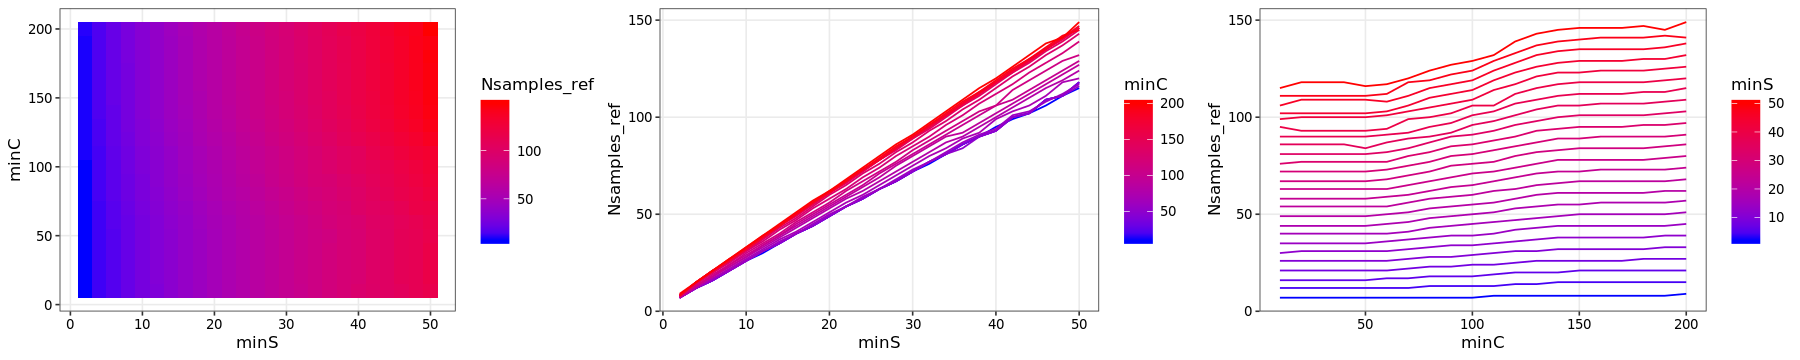

In [151]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CS"],(aes(x=minS,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CS"],(aes(x=minS,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CS"],(aes(x=minC,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

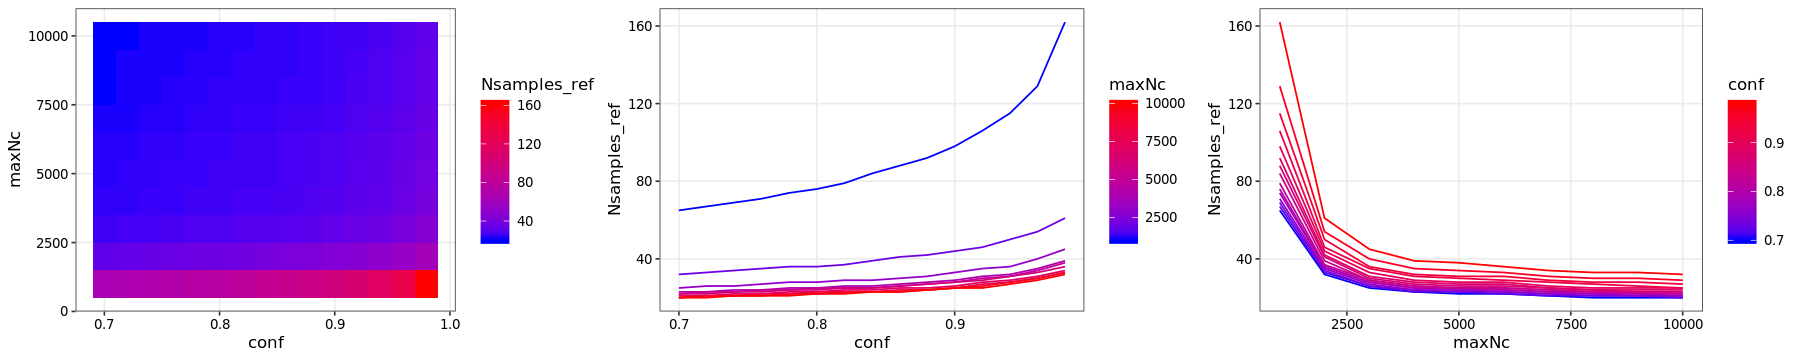

In [154]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="NCo"],(aes(x=conf,y=maxNc,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="NCo"],(aes(x=conf,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="NCo"],(aes(x=maxNc,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

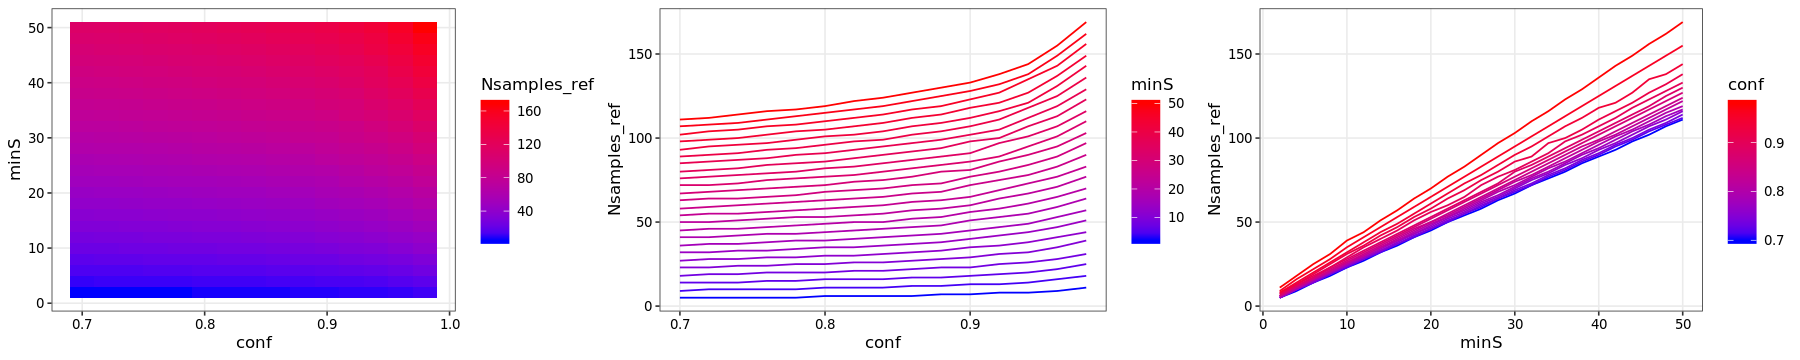

In [155]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="SCo"],(aes(x=conf,y=minS,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="SCo"],(aes(x=conf,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="SCo"],(aes(x=minS,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

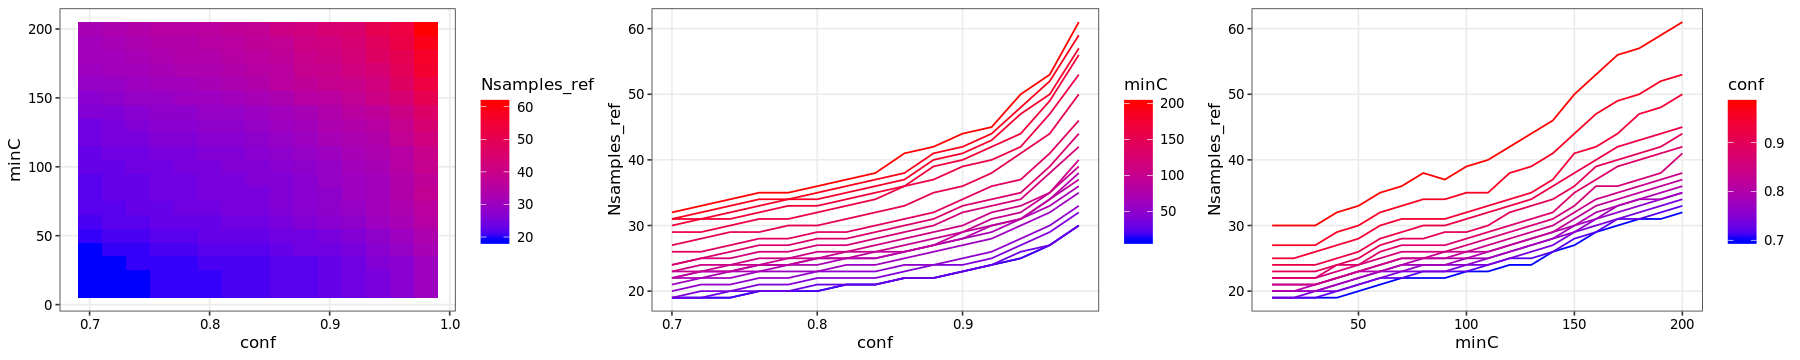

In [156]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CCo"],(aes(x=conf,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CCo"],(aes(x=conf,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CCo"],(aes(x=minC,y=Nsamples_ref,group=conf,col=conf)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

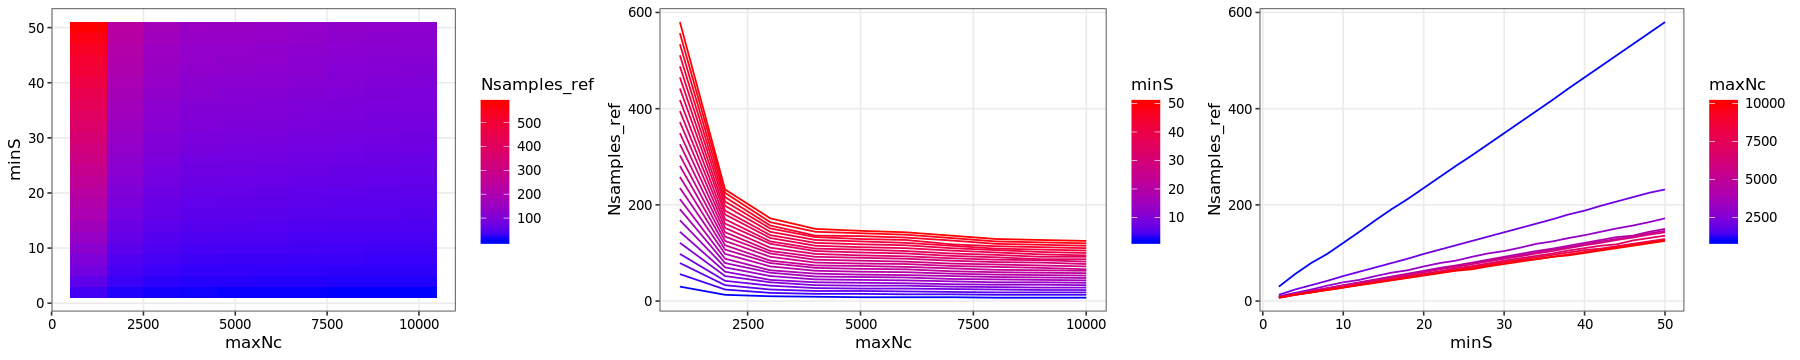

In [157]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="SN"],(aes(x=maxNc,y=minS,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="SN"],(aes(x=maxNc,y=Nsamples_ref,group=minS,col=minS)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="SN"],(aes(x=minS,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

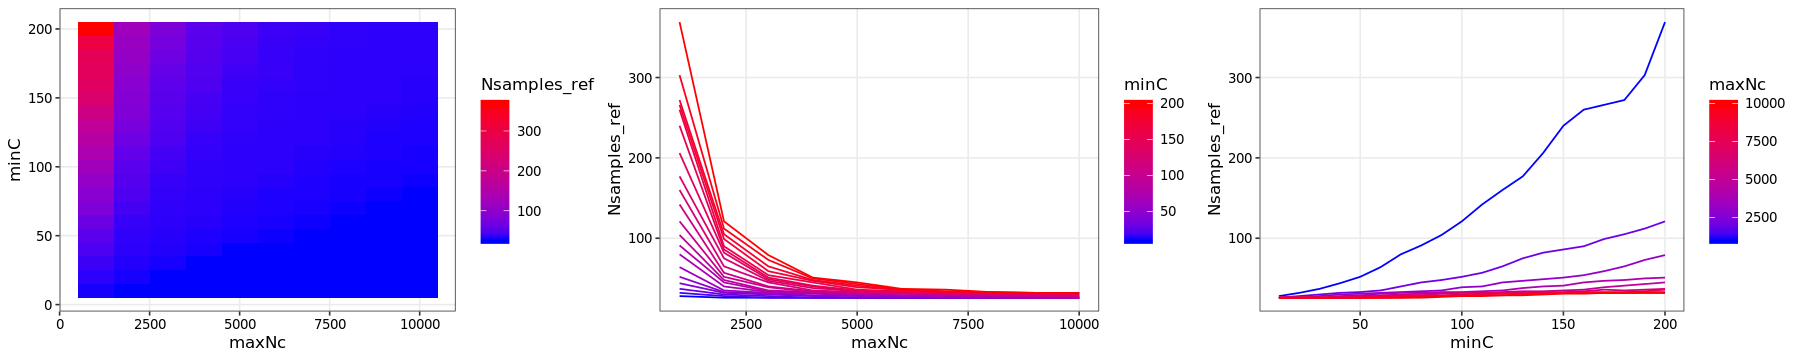

In [158]:
options(repr.plot.width = 15, repr.plot.height =3)
p1=ggplot(res[set=="CN"],(aes(x=maxNc,y=minC,fill=Nsamples_ref)))+geom_tile()+scale_fill_gradient(high="red",low="blue")
p2=ggplot(res[set=="CN"],(aes(x=maxNc,y=Nsamples_ref,group=minC,col=minC)))+geom_line()+scale_color_gradient(high="red",low="blue")
p3=ggplot(res[set=="CN"],(aes(x=minC,y=Nsamples_ref,group=maxNc,col=maxNc)))+geom_line()+scale_color_gradient(high="red",low="blue")
cowplot::plot_grid(p1,p2,p3,ncol=3)

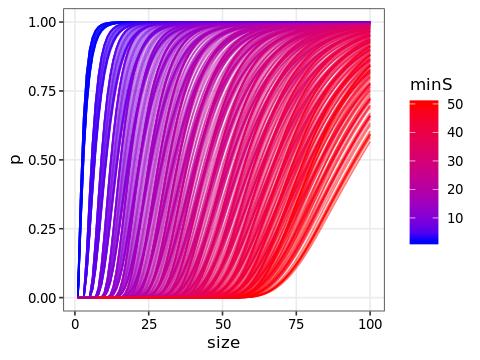

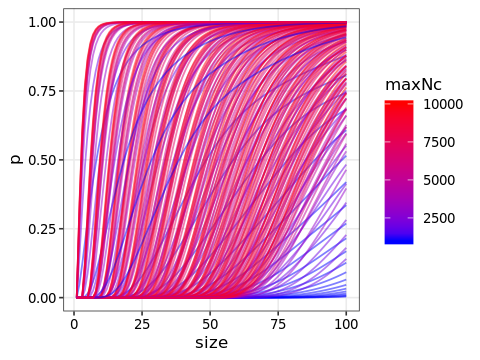

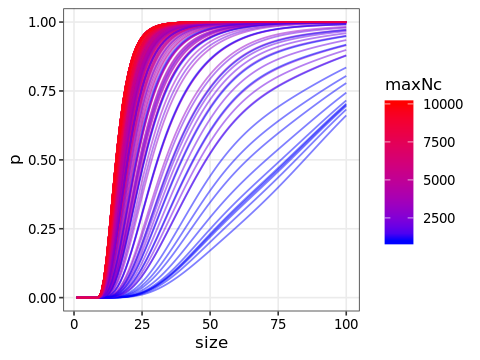

In [175]:
options(repr.plot.width = 4, repr.plot.height =3)
ggplot(ps[set=="CS"],(aes(x=size,y=p,group=paste0(minC,minS),col=minS)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")
ggplot(ps[set=="SN"],(aes(x=size,y=p,group=paste0(minS,maxNc),col=maxNc)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")
ggplot(ps[set=="CN"],(aes(x=size,y=p,group=paste0(minC,maxNc),col=maxNc)))+geom_line(alpha=0.5)+scale_color_gradient(high="red",low="blue")